# Main notebook for making mutation figures

In [1]:
from collections import defaultdict, Counter
import pandas as pd
from scipy import stats as sci_stats
from matplotlib import pyplot as pl
from matplotlib import cm
import numpy as np
import seaborn as sns
from glob import glob
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, to_rgba
from statsmodels.stats.multitest import fdrcorrection as benjamini_hochberg
from matplotlib.patches import Rectangle

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
plates = ['P1', 'P2', 'P3']
plate2env = {'P1': r'YPD 30$\degree$C', 'P2': r'SC 30$\degree$C', 'P3': r'SC 37$\degree$C'}
strains = ['diploid', 'alpha', 'a']
strains_for_print = {'a': '$MATa$', 'diploid': 'Diploid', 'alpha': r'$MAT\alpha$'}
color_by_strain = {'diploid': '#555555', 'alpha': '#FFB000', 'a': '#648FFF'}
fa_gens = [70, 550, 1410, 2640, 3630, 5150, 7530, 10150]
seq_gens = [70, 1410, 2640, 5150, 7530, 10150]
# This dictionary changes the recorded generation numbers to the correct generation numbers
# Since P3 only does 8 gens/day it is very different, the other differences are due to little recording errors
gen_fixer = {70: {'P1': 70, 'P2': 70, 'P3': 56, 'P4': 70},
             550: {'P1': 560, 'P2': 560, 'P3': 448, 'P4': 560},
             1410: {'P1': 1410, 'P2': 1410, 'P3': 1128, 'P4': 1410},
             2640: {'P1': 2640, 'P2': 2640, 'P3': 2104, 'P4': 2640},
             3630: {'P1': 3660, 'P2': 3660, 'P3': 2920, 'P4': 3660},
             5150: {'P1': 5170, 'P2': 5170, 'P3': 4128, 'P4': 5170},
             7530: {'P1': 7550, 'P2': 7560, 'P3': 6040, 'P4': 7560},
             10150: {'P1': 10190, 'P2': 10200, 'P3': 8096, 'P4': 10200}}
all_wells = sorted([i.split('/')[-1].split('_')[0] for i in glob('../../Output/WGS/combined_option/processed_well_output/*_processed.tsv')])
wells = [w for w in all_wells if w!='P1B03'] #P1B03 excluded because it is a haploid population that diploidized
gene_info = pd.read_csv('../accessory_files/yeast_gene_annotations.tsv', delimiter='\t')
gene_info = gene_info[gene_info['featureType']=='ORF'].loc[gene_info['briefDescription'].apply(lambda bd: ('Putative protein' not in bd) and ('Dubious open reading frame' not in bd))]
gene_to_start_end = {i[0]: i[1:] for i in gene_info.as_matrix(['Gene_ORF', 'start', 'end'])}
orf_sizes = list(gene_info['end']-gene_info['start'])

essential_orfs_by_Liu = list(gene_info[gene_info['Essential_by_Liu2015']]['ORF'])
essential_orfs_by_Gaiever_not_Liu = [i for i in gene_info[gene_info['Essential_by_Giaever2002']]['ORF'] if i not in essential_orfs_by_Liu]

o2g = {i[0]:i[1] for i in gene_info.as_matrix(['ORF', 'Gene_ORF']) if pd.notnull(i[1])}
o2g.update({i[0]:i[0] for i in gene_info.as_matrix(['ORF', 'Gene_ORF']) if pd.isnull(i[1])})
g2o = {o2g[o]:o for o in o2g}
wellinfo = pd.read_csv('../accessory_files/VLTE_by_well_info.csv')[['platewell', 'contam', 'strain']]
well_to_strain = {i[0]:i[1] for i in wellinfo.as_matrix(['platewell', 'strain'])}
wells_w_ade2_stop_lost = ['P2F07', 'P1C09', 'P1E11', 'P3B10', 'P2B09']
cb_pal = sns.color_palette('colorblind')

## Loading mutation data for next figures

## Some code for calculating mutational opportunities:

In [3]:
nt2codon = {
    'TTT': 'F', 'TTC': 'F',
    'TTA': 'L', 'TTG': 'L', 'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
    'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S', 'AGT': 'S', 'AGC': 'S',
    'TAT': 'Y', 'TAC': 'Y',
    'TAA': '*', 'TAG': '*', 'TGA': '*',
    'TGT': 'C', 'TGC': 'C',
    'TGG': 'W',
    'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
    'CAT': 'H', 'CAC': 'H',
    'CAA': 'Q', 'CAG': 'Q',
    'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R', 'AGA': 'R', 'AGG': 'R',
    'ATT': 'I', 'ATC': 'I', 'ATA': 'I',
    'ATG': 'M',
    'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
    'AAT': 'N', 'AAC': 'N',
    'AAA': 'K', 'AAG': 'K',
    'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
    'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
    'GAT': 'D', 'GAC': 'D',
    'GAA': 'E', 'GAG': 'E',
    'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'
}

def get_attrib(row, attrib):
    if row['type']=='gene':
        if attrib+'=' in row['attributes']:
            return row['attributes'].split(attrib+'=')[1].split(';')[0]
    return ''

def read_fasta(fasta_file):
    """
    Reads a fasta file and returns a dictionary with seqid keys and sequence values
    """
    fd = dict()
    with open(fasta_file, 'r') as infile:
        for line in infile:
            if '>' in line:
                current_key = line[1:].strip()
                fd[current_key] = ''
            else:
                fd[current_key] += line.strip()
    return fd

def reverse_transcribe(seq):
    """reverse transcribes a dna sequence (does not convert any non-atcg/ATCG characters)"""
    watson_crick = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G', 'a': 't', 't': 'a', 'g': 'c', 'c': 'g'}
    return ''.join([watson_crick.setdefault(c, c) for c in seq[::-1]])

class SeqInfoGetter:
    
    def __init__(self, gff_file, fasta_file):
        gff_cols = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
        self.gff = pd.read_csv(gff_file, delimiter='\t', skiprows=1, header=None, names=gff_cols)
        self.gff['ORF'] = self.gff.apply(lambda row: get_attrib(row, "ID"), axis=1)
        self.genes = self.gff[self.gff['ORF']!='']
        self.genes['Gene'] = self.genes.apply(lambda row: get_attrib(row, "gene"), axis=1)
        self.chromo_seqs = read_fasta(fasta_file)
    
    def get_nt_seq(self, element_name, element_type):
        td = self.genes[self.genes[element_type]==element_name]
        if len(td) != 1:
            print(len(td), 'hits, aborting.')
            return None
        else:
            row = td.iloc[0]
            cs = self.chromo_seqs[row['seqid']]
            if row['strand'] == '+':
                return cs[row['start']-1:row['end']]
            else:
                return reverse_transcribe(cs[row['start']-1:row['end']])
            
    def get_aa_seq(self, element_name, element_type):
        nt_s = self.get_nt_seq(element_name, element_type)
        if nt_s:
            aas = ''
            for i in range(len(nt_s)//3):
                aas += nt2codon[nt_s[i*3:(i+1)*3]]
            if len(nt_s) % 3 != 0:
                aas += '-leftover->' + nt_s[-1*(len(nt_s) % 3):]
            return aas
            
    def get_mutational_opps(self, element_name, element_type, verbose=False, return_nonsyn_over_all=False):
        nt_s = self.get_nt_seq(element_name, element_type)
        if nt_s:
            if len(nt_s) % 3 != 0:
                if verbose:
                    print('Warning: seq len not a multiple of 3', element_name)
                    print(self.genes[self.genes[element_type]==element_name].iloc[0]['Gene'])
                    print(self.get_aa_seq(element_name, element_type))
           
            syn, nonsyn = 0, 0
            for i in range(len(nt_s)//3):
                codon_seq = nt_s[i*3:(i+1)*3]
                codes_for = nt2codon[codon_seq]
                for j in range(3):
                    for nt in 'ATCG':
                        if nt != codon_seq[j]:
                            if nt2codon[codon_seq[:j]+nt+codon_seq[j+1:]] == codes_for:
                                syn += 1
                            else:
                                nonsyn += 1
            if return_nonsyn_over_all:
                return nonsyn/(syn+nonsyn)
            else:
                return nonsyn / syn

In [4]:
seqI = SeqInfoGetter('../../Output/WGS/reference/w303_vlte.gff', '../../Output/WGS/reference/w303_vlte.fasta')

In [5]:
orf_lens = {o: len(seqI.get_nt_seq(o, "ORF")) for o in seqI.genes['ORF']}
orf_mutational_opp_ratios = {o: seqI.get_mutational_opps(o, "ORF") for o in seqI.genes['ORF']} # Yeilds % of nonsyn/syn random mutations in each ORF
orf_mutational_nonsyn_opps = {o: seqI.get_mutational_opps(o, "ORF", return_nonsyn_over_all=True)*orf_lens[o] for o in seqI.genes['ORF']} # Yeilds % of nonsyn/syn random mutations in each ORF
total_len = np.sum(list(orf_lens.values()))
total_nonsyn_ratio = np.sum([orf_mutational_opp_ratios[o]*orf_lens[o]/total_len for o in orf_lens])
total_nonsyn_ratio

3.70897210627441

In [6]:
def hit_orfs(orf_list, search_list):
    for o in str(orf_list).split(';'):
        if o in search_list:
            return True
    return False

# by well dataframes with mutations
well_dats = dict()
for well in all_wells:
    well_dats[well] = pd.read_csv('../../Output/WGS/combined_option/processed_well_output/' + well + '_processed.tsv', delimiter='\t')
    # Exclude from analysis mutations in the 2-micron plasmid and telomeres, and SVs
    well_dats[well] = well_dats[well][pd.isnull(well_dats[well]['SVTYPE']) & (well_dats[well]['CHROM']!='2-micron') & (~well_dats[well]['in_telomere'])]

# a dataframe looking at which types of mutations fix across wells
mutation_types_in_consequence_order = ['indel', 'nonsense', 'missense', 'synonymous', 'noncoding']
big_mat = []
for well in wells:
    current_strain = well_to_strain[well]
    current_well_dat = well_dats[well]
    dat_types = ['All', 'Essential']
    tmplate = [well, current_strain, well[:2]]
    wd = current_well_dat[current_well_dat['fixed_by_10150']]
    # Getting a second dataframe that just includes mutations in essential genes
    dats_to_use = [wd, wd[wd.apply(lambda r: hit_orfs(r['ORF_hit'], essential_orfs_by_Liu) or hit_orfs(r['ORF_hit_synonymous'], essential_orfs_by_Liu), axis=1)]]
    for t in range(2):
        td = dats_to_use[t]
        tmp = tmplate[:] + [dat_types[t]]
        for m in mutation_types_in_consequence_order:
            tmp.append(len(set(td[td['group_mutation_type']==m]['mutation_group'])))
        for mut_impact in ['HIGH', 'MODERATE', 'LOW', 'MODIFIER']:
            tmp.append(len(set(td[td['ANN_simpler'].apply(lambda a: mut_impact in str(a))]['mutation_group'])))

        big_mat.append(tmp)
    
mut_type_cols = mutation_types_in_consequence_order+['HIGH', 'MODERATE', 'LOW', 'MODIFIER']
well_muts_fixed = pd.DataFrame(big_mat, columns=['Well', 'Strain', 'Plate', 'Gene Set']+mut_type_cols)
well_muts_fixed['Condition'] = well_muts_fixed.apply(lambda row: strains_for_print[row['Strain']]+'\n'+plate2env[row['Plate']], axis=1)
# dN/dS is scaled by the ratio of nonsynonymous/synonmous mutation opportunities in all ORFs:
well_muts_fixed['dN/dS'] = ((well_muts_fixed['missense']+well_muts_fixed['nonsense'])/well_muts_fixed['synonymous']) / total_nonsyn_ratio
well_muts_fixed['percent_indel'] = well_muts_fixed['indel']/np.sum(well_muts_fixed[mutation_types_in_consequence_order], axis=1)

# a dataframe of info on multi-hit genes
multi_hit_df = pd.read_csv('../../Output/WGS/combined_option/multi_hit_genes.tsv', delimiter='\t')
multi_hit_orfs = list(multi_hit_df['ORF'])

# a dataframe with hits and multiplicity for each ORF in the yeast genome
orf_hit_df = pd.read_csv('../../Output/WGS/combined_option/gene_hit_data.tsv', delimiter='\t')
orf_hit_df = orf_hit_df.merge(gene_info[['ORF', 'briefDescription', 'Essential_by_Liu2015', 'Essential_by_Giaever2002', 'start', 'end']], on='ORF', how='left')
mhcols = ['ORF'] + ['model'+m+s for m in ['2', '3', '4'] for s in ['_LL_ratio','_LL_ratio_p','_LL_ratio_p_corrected']] + ['AIC_model4_v_2','AIC_model4_v_3','dependent_on']
all_gene_hit_info = orf_hit_df.merge(multi_hit_df[mhcols], on='ORF', how='left')

In [7]:
all_gene_hit_info.to_csv('../../Output/WGS/combined_option/gene_hit_data_plus.tsv', sep='\t', index=False)
well_muts_fixed[[i for i in well_muts_fixed if i!='Condition']].to_csv('../../Output/WGS/combined_option/fixed_mutation_breakdown.tsv', sep='\t', index=False)

## seperate figs option

In [8]:
ade_orfs = ['YDR408C', # ADE8
            'YGR061C', # ADE6 
            'YOR128C', # ADE2
            'YGL234W', # ADE5,7
            'YMR300C', # ADE4
            'YGR204W'] # ADE3  

ade_color = cb_pal[3]

def plot_trajectories(td, sub, plate, only_non_syn=True, only_syn=False, only_orfs=False, opac=0.8, colora='k', lw=1, ls='-', count_thresh=4, g_mutation_type=None):
    if only_non_syn:
        td = td[pd.notnull(td['ORF_hit'])]
        if only_orfs:
            td = td[td['ORF_hit'].apply(lambda r: hit_orfs(r, only_orfs))]
    elif only_syn:
        td = td[pd.isnull(td['ORF_hit'])]
    if g_mutation_type:
        td = td[td['group_mutation_type']==g_mutation_type]
        
    for i, entry in td.iterrows():
        use_gens, freqs = [], []
        for gen in seq_gens:
            if 'G'+str(gen)+'_alt_counts' in entry:
                tot_counts = entry['G'+str(gen)+'_alt_counts'] + entry['G'+str(gen)+'_ref_counts']
                if tot_counts >= count_thresh:
                    use_gens.append(gen_fixer[gen][plate])
                    freqs.append(entry['G'+str(gen)+'_alt_counts']/tot_counts)
        if len(use_gens) > 0:
            sub.plot(use_gens, freqs, color=colora, alpha=opac, lw=lw, linestyle=ls)

def basic_traj_plot(well, sub, plate, plot_ades=True):
    plot_trajectories(well_dats[well], sub, plate, only_non_syn=False, only_syn=True, opac=0.2, lw=0.5, ls=':')
    plot_trajectories(well_dats[well], sub, plate, opac=0.2, lw=0.5, ls='-')
    plot_trajectories(well_dats[well], sub, plate, only_orfs=multi_hit_orfs, lw=0.75)
    if plot_ades:
        plot_trajectories(well_dats[well], sub, plate, only_orfs=ade_orfs, lw=1.5, colora=ade_color, opac=1)
    sub.set_title(well + ': ' + strains_for_print[well_to_strain[well]] + ', ' + plate2env[plate], fontsize=10)

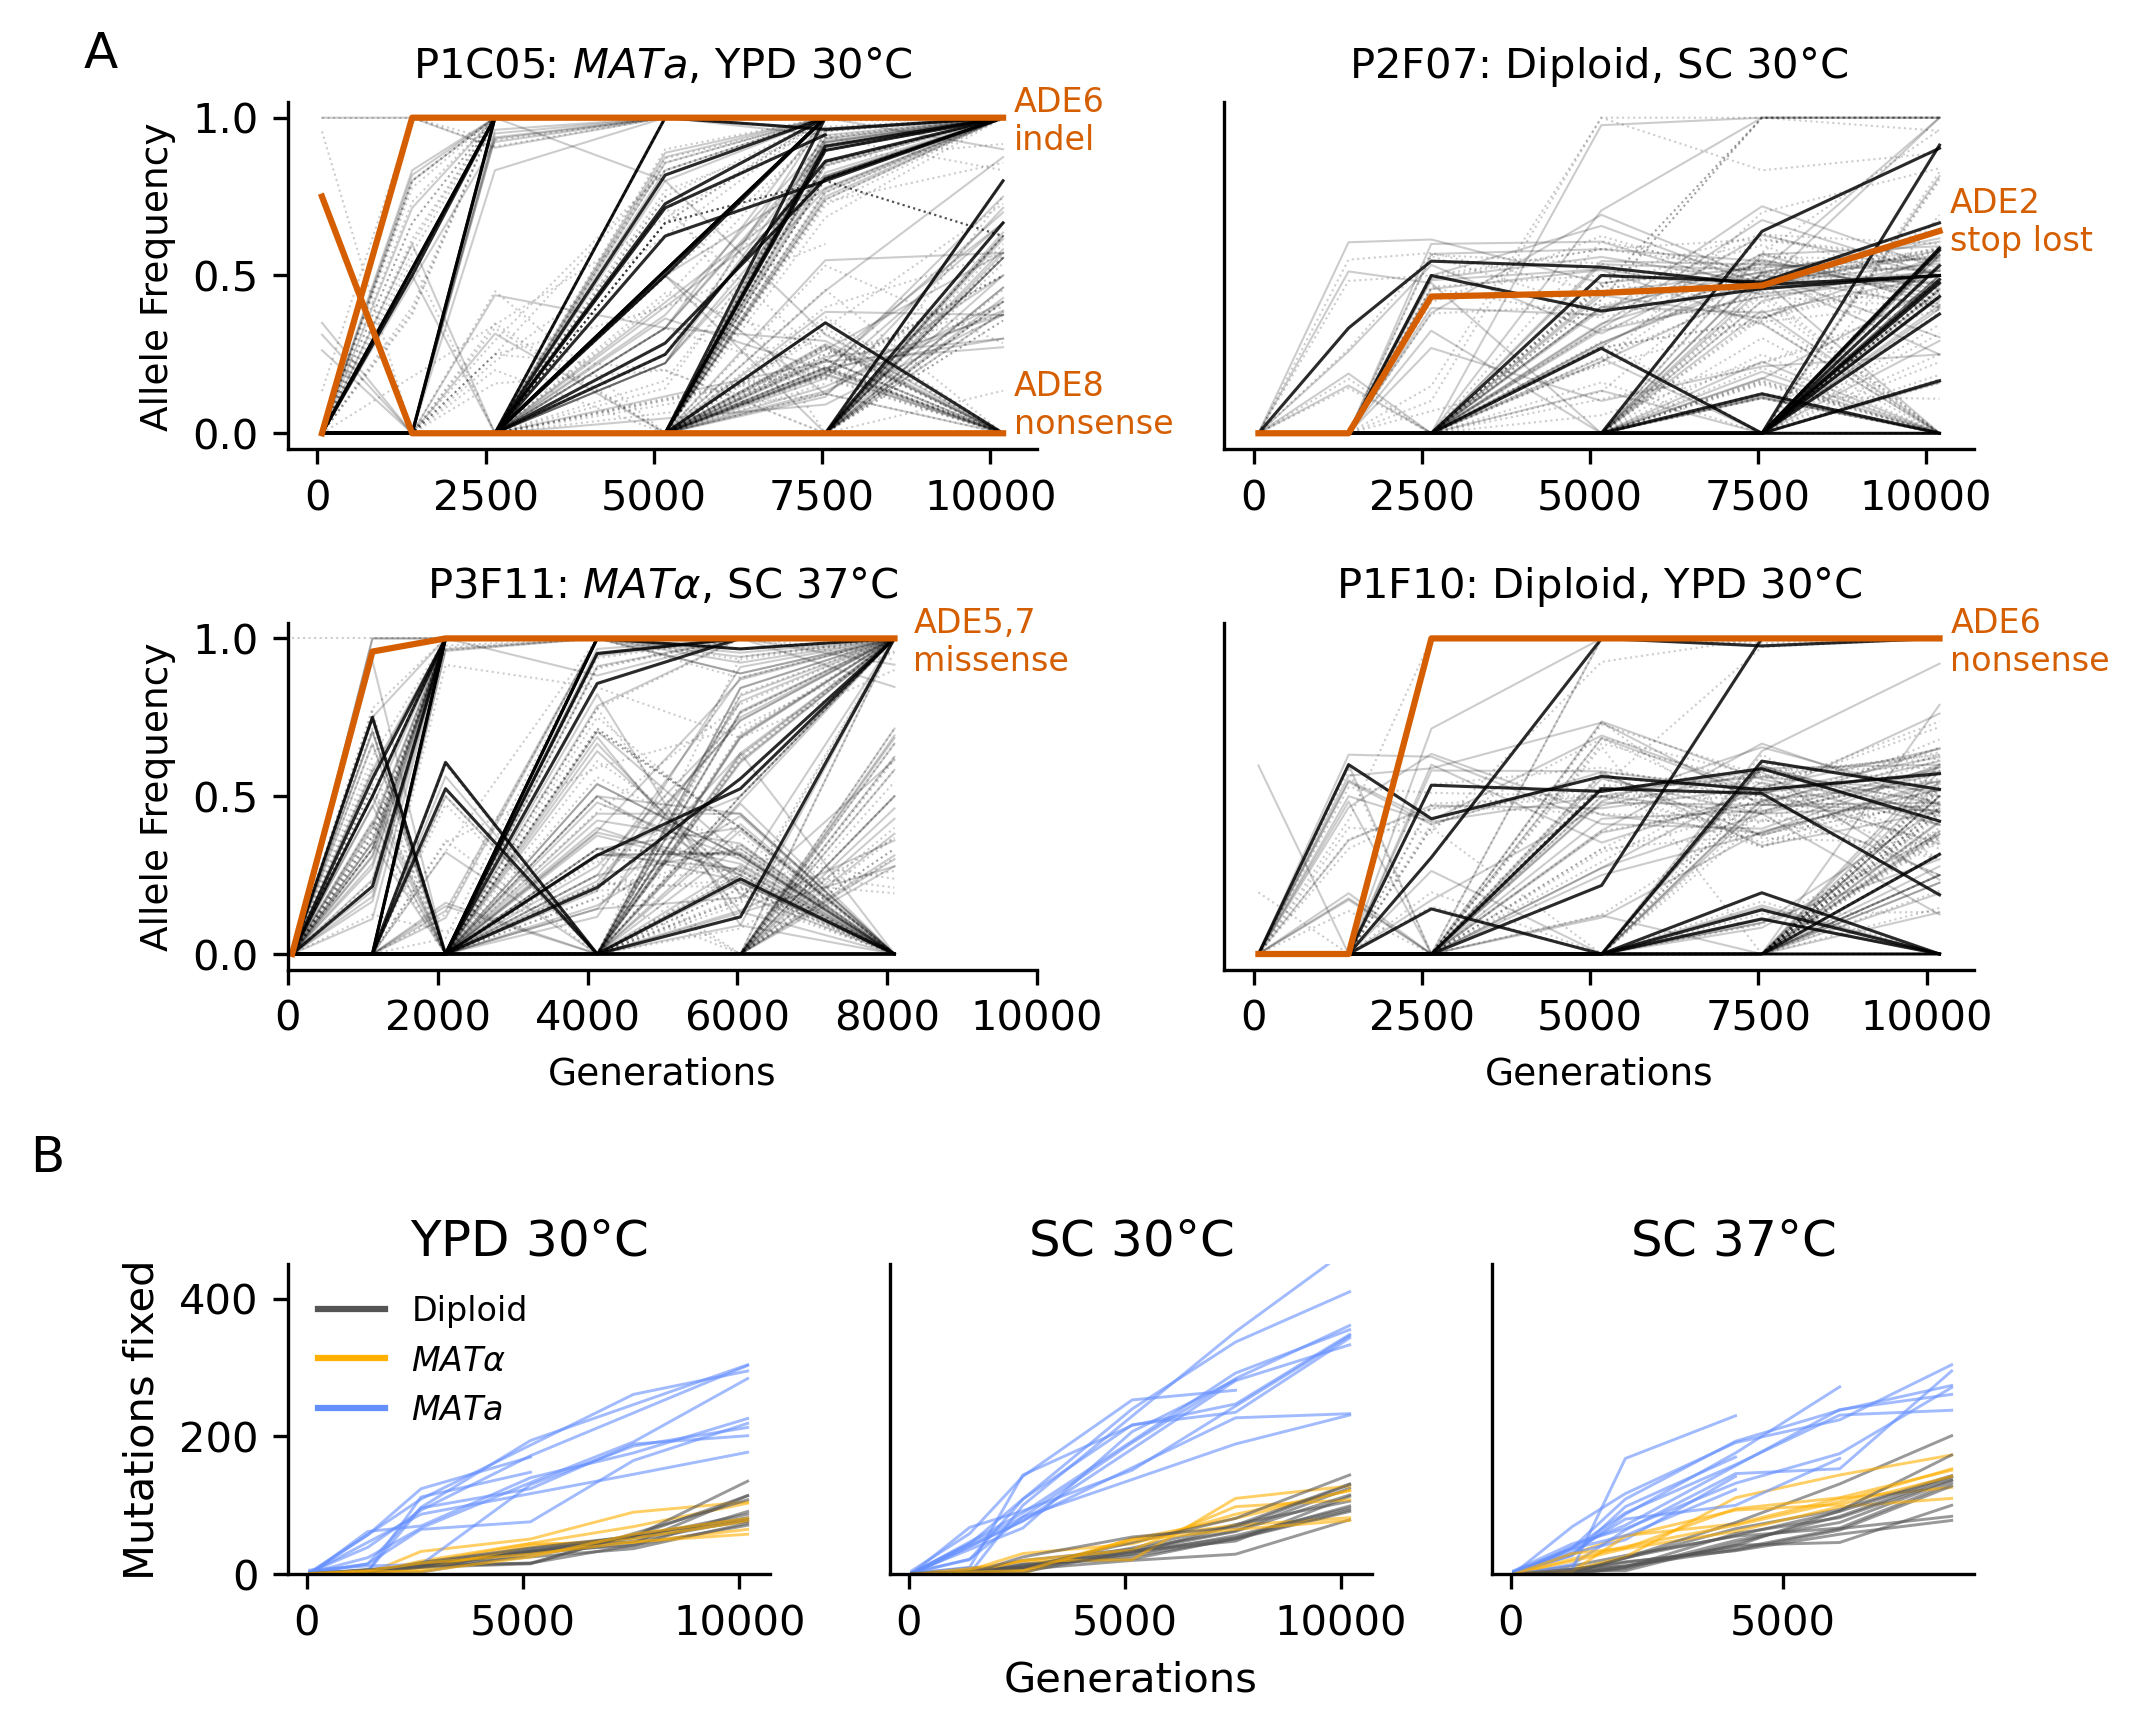

In [9]:
f = pl.figure(figsize=(7.25, 6.5), dpi=300)
pl.subplots_adjust(wspace=0.25)
gs0 = gridspec.GridSpec(32,20)
example_gs = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[:19,:])
example_subs = [pl.Subplot(f, example_gs[i, j]) for i in range(2) for j in range(2)]
jnk = [f.add_subplot(s) for s in example_subs]

basic_traj_plot('P1C05', example_subs[0], 'P1')
example_subs[0].annotate('ADE8\nnonsense', (10350, 0), color=ade_color, fontsize=8)
example_subs[0].annotate('ADE6\nindel', (10350, 0.9), color=ade_color, fontsize=8)

basic_traj_plot('P2F07', example_subs[1], 'P2')
example_subs[1].annotate('ADE2\nstop lost', (10350, 0.58), color=ade_color, fontsize=8)

basic_traj_plot('P3F11', example_subs[2], 'P3')
example_subs[2].annotate('ADE5,7\nmissense', (8350, 0.9), color=ade_color, fontsize=8)
basic_traj_plot('P1F10', example_subs[3], 'P1')
example_subs[3].annotate('ADE6\nnonsense', (10350, 0.9), color=ade_color, fontsize=8)

example_subs[2].set_xlabel('Generations', fontsize=9)
example_subs[3].set_xlabel('Generations', fontsize=9)
example_subs[0].set_ylabel('Allele Frequency', fontsize=9)
example_subs[2].set_ylabel('Allele Frequency', fontsize=9)
example_subs[2].set_xlim([0,10000])
example_subs[1].set_yticks([])
example_subs[3].set_yticks([])


example_gs = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[25:32,:])
subs = [pl.Subplot(f, example_gs[i]) for i in range(3)]
jnk = [f.add_subplot(subs[i]) for i in range(3)]
pl.subplots_adjust(hspace=0.5)
cov_thresh = {'a': 10, 'alpha': 10, 'diploid':20}
for p in range(3):
    use_wells = [w for w in wells if w[:2]==plates[p]]
    for well in use_wells:
        current_strain = well_to_strain[well]
        td = well_dats[well]
        use_gens, mut_present_counts, mut_fixed_counts = [], [], []
        max_fixed = len(set(td[td['fixed_by_10150']]['mutation_group']))
        for gen in seq_gens:
            if 'G'+str(gen)+'_alt_counts' in td:
                coverage = np.nansum(td[['G'+str(gen)+'_alt_counts', 'G'+str(gen)+'_ref_counts']])/len(td)
                if coverage >= cov_thresh[current_strain]:
                    use_gens.append(gen_fixer[gen][plates[p]])
                    mut_fixed_counts.append(len(set(td[td['fixed_by_'+str(gen)]]['mutation_group'])))
                    mut_present_counts.append(len(set(td[td['present_at_'+str(gen)]]['mutation_group'])))
        subs[p].plot(use_gens, mut_fixed_counts, c=color_by_strain[well_to_strain[well]], lw=0.7, alpha=0.6)
        subs[p].set_ylim([0,450])
    subs[p].set_title(plate2env[plates[p]], y=0.95)
    if p > 0:
        subs[p].set_yticks([])


for i in color_by_strain:    
    subs[0].plot([], [], c=color_by_strain[i], label=strains_for_print[i])

subs[0].legend(frameon=False, fontsize=8)
subs[0].set_ylabel('Mutations fixed')
subs[1].set_xlabel('Generations')

example_subs[0].annotate('A', fontsize=12, xy=(-0.25, 1.1), xycoords="axes fraction", horizontalalignment="center")
subs[0].annotate('B', fontsize=12, xy=(-0.5, 1.3), xycoords="axes fraction", horizontalalignment="center")

sns.despine()
f.savefig('../../FINAL_FIGURES/Fig3.pdf', background='transparent', bbox_inches='tight', pad_inches=0.1)

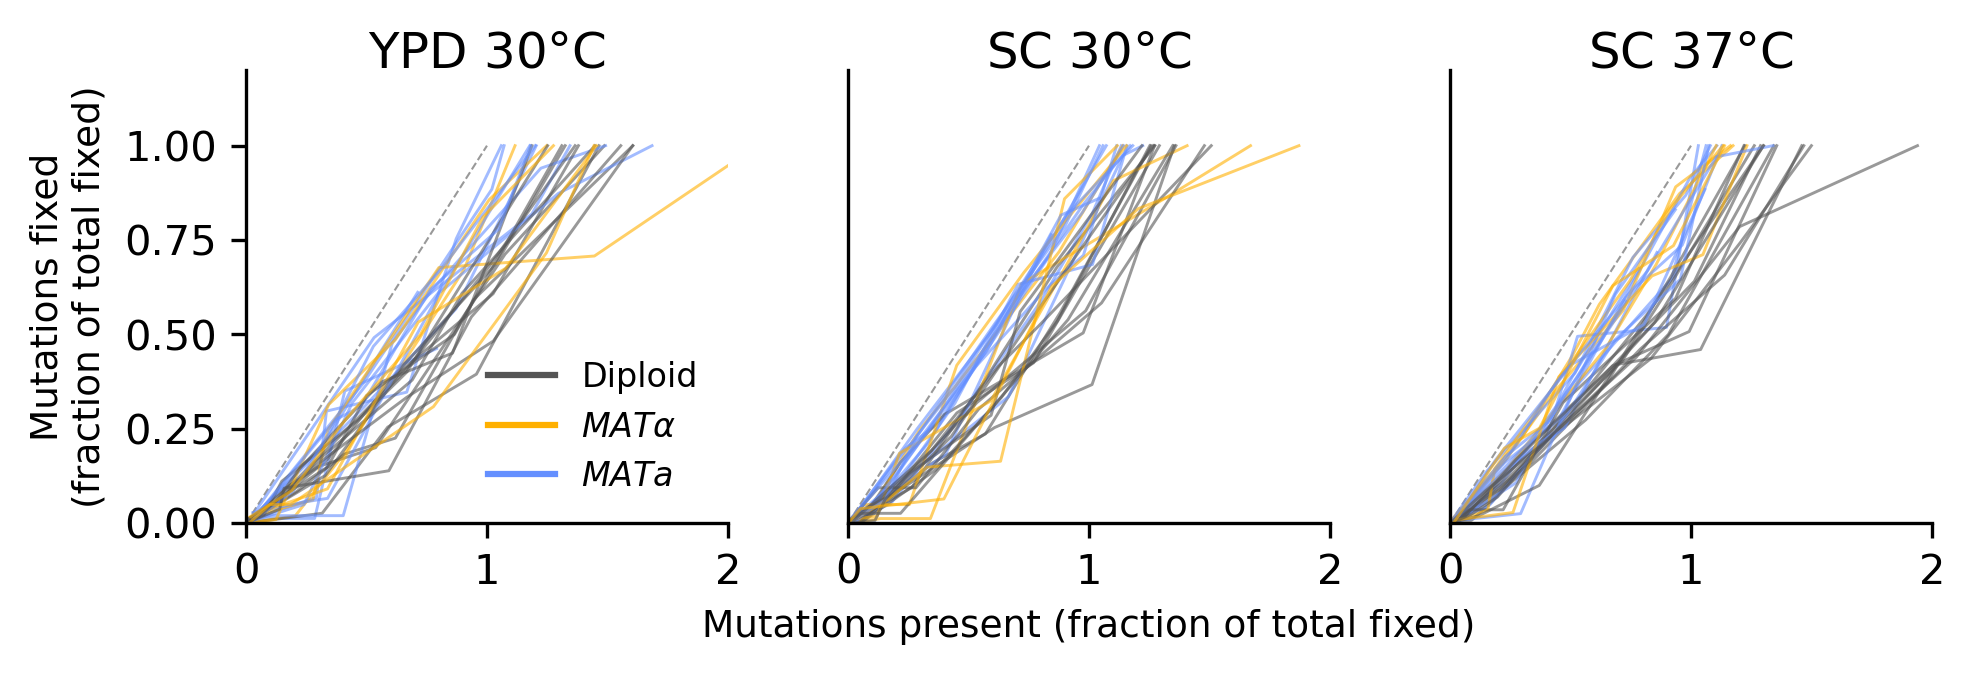

In [10]:
f, subs2 = pl.subplots(1, 3, figsize=(7.25, 2), dpi=300)
pl.subplots_adjust(wspace=0.25)

cov_thresh = {'a': 10, 'alpha': 10, 'diploid':20}
for p in range(3):
    use_wells = [w for w in wells if w[:2]==plates[p]]
    subs2[p].plot([0,1], [0,1], c='k', linestyle='dashed', lw=0.5, alpha=0.4)
    for well in use_wells:
        current_strain = well_to_strain[well]
        td = well_dats[well]
        use_gens, mut_present_counts, mut_fixed_counts = [], [], []
        max_fixed = len(set(td[td['fixed_by_10150']]['mutation_group']))
        for gen in seq_gens:
            if 'G'+str(gen)+'_alt_counts' in td:
                coverage = np.nansum(td[['G'+str(gen)+'_alt_counts', 'G'+str(gen)+'_ref_counts']])/len(td)
                if coverage >= cov_thresh[current_strain]:
                    use_gens.append(gen_fixer[gen][plates[p]])
                    mut_fixed_counts.append(len(set(td[td['fixed_by_'+str(gen)]]['mutation_group'])))
                    mut_present_counts.append(len(set(td[td['present_at_'+str(gen)]]['mutation_group'])))
        subs2[p].plot(np.array(mut_present_counts)/max_fixed, np.array(mut_fixed_counts)/max_fixed, c=color_by_strain[well_to_strain[well]], lw=0.7, alpha=0.6)
        subs2[p].set_xlim([0,2])
        subs2[p].set_ylim([0,1.2])
    subs2[p].set_title(plate2env[plates[p]], y=0.95)
    if p > 0:
        subs2[p].set_yticks([])

subs2[0].set_ylabel('Mutations fixed\n(fraction of total fixed)', fontsize=9)
subs2[1].set_xlabel('Mutations present (fraction of total fixed)', fontsize=9)

for i in color_by_strain:    
    subs2[0].plot([], [], c=color_by_strain[i], label=strains_for_print[i])

subs2[0].legend(frameon=False, fontsize=8)

sns.despine()
f.savefig('../../FINAL_FIGURES/supp/Fig3Supp10.pdf', background='transparent', bbox_inches='tight', pad_inches=0.1)

## Supp figs - allele trajectories for all of em

In [11]:
supp = 1
for plate in plates:
    for strain in ['diploid', 'a', 'alpha']:
        nrows = {'a': 6, 'diploid':6, 'alpha':3}[strain]
        f, subps = pl.subplots(nrows, 2, figsize=(7.25, 10*(nrows/6)), dpi=300, sharex=True, sharey=True)
        pl.subplots_adjust(hspace=0.4)
        #f.suptitle(plate2env[plate] + ' ' + strains_for_print[strain])
        subs = [subps[i][j] for i in range(nrows) for j in range(2)]
        wells_use = [w for w in all_wells if w[:2]==plate and well_to_strain[w]==strain]
        for i in range(len(wells_use)):
            basic_traj_plot(wells_use[i], subs[i], plate)
        for i in range(2):
            subs[-1*i-1].set_xlabel('Generations', fontsize=9)
        for j in range(nrows):
            subs[j*2].set_ylabel('Allele Freqency', fontsize=9)
        sns.despine()
        f.savefig('../../FINAL_FIGURES/supp/Fig3Supp' + str(supp) + '_' + plate + '_' + strain + '_allele_freqs.pdf', background='transparent', bbox_inches='tight', pad_inches=0.1)
        pl.close(f)
        supp += 1

# FIGURE 4: WHAT ARE THESE MUTATIONS?

## Significance testing for dN/dS. I test differences between environments here, but I don't report them since P3 has fewer generations, and in general there could be so many things causing this difference.

In [12]:
mat = []
use = well_muts_fixed[well_muts_fixed['Gene Set']=='All']
print('Testing strain only:')
for i in range(3):
    for j in range(i+1, 3):
        d1 = use[use['Strain']==strains[i]].loc[use['synonymous']!=0]['dN/dS']
        d2 = use[use['Strain']==strains[j]].loc[use['synonymous']!=0]['dN/dS']
        print(strains[i], strains[j], '\t', sci_stats.mannwhitneyu(list(d1), list(d2))[1])
        mat.append(['dN/dS', 'All wells', strains[i], strains[j], len(d1), len(d2), np.nanmean(d1), np.nanmean(d2), sci_stats.mannwhitneyu(list(d1), list(d2))[1]])

print('Testing strain w/in plate:')
for plate in plates:
    td = use[use['Plate']==plate]
    for i in range(3):
        for j in range(i+1, 3):
            d1 = td[td['Strain']==strains[i]].loc[td['synonymous']!=0]['dN/dS']
            d2 = td[td['Strain']==strains[j]].loc[td['synonymous']!=0]['dN/dS']
            print(plate, strains[i], strains[j], '\t', sci_stats.mannwhitneyu(list(d1), list(d2))[1], np.mean(d1), np.mean(d2))
            mat.append(['dN/dS', plate, strains[i], strains[j], len(d1), len(d2), np.nanmean(d1), np.nanmean(d2), sci_stats.mannwhitneyu(list(d1), list(d2))[1]])

Testing strain only:
diploid alpha 	 0.16311641329499577
diploid a 	 0.0017751638388907927
alpha a 	 0.0002470694421999993
Testing strain w/in plate:
P1 diploid alpha 	 0.4813246420648549 1.051684922122997 1.0799726585537246
P1 diploid a 	 0.0830599852247938 1.051684922122997 0.8071981062865511
P1 alpha a 	 0.07251612678934108 1.0799726585537246 0.8071981062865511
P2 diploid alpha 	 0.4074356419493555 0.9927035678000538 1.1781303439471684
P2 diploid a 	 0.33250277105101456 0.9927035678000538 0.9583252888612552
P2 alpha a 	 0.3367082873168834 1.1781303439471684 0.9583252888612552
P3 diploid alpha 	 0.21298755575680278 1.1916363402323056 1.3077513537085208
P3 diploid a 	 0.0055284779073269865 1.1916363402323056 0.7893202340685312
P3 alpha a 	 0.0004422835781525009 1.3077513537085208 0.7893202340685312


In [13]:
pd.DataFrame(mat, columns=['Test', 'Plate', 'Strain1', 'Strain2', 'N1', 'N2', 'mean1', 'mean2', 'P-value']).to_csv('../../Output/WGS/combined_option/dnds_stat_record.csv', index=False)

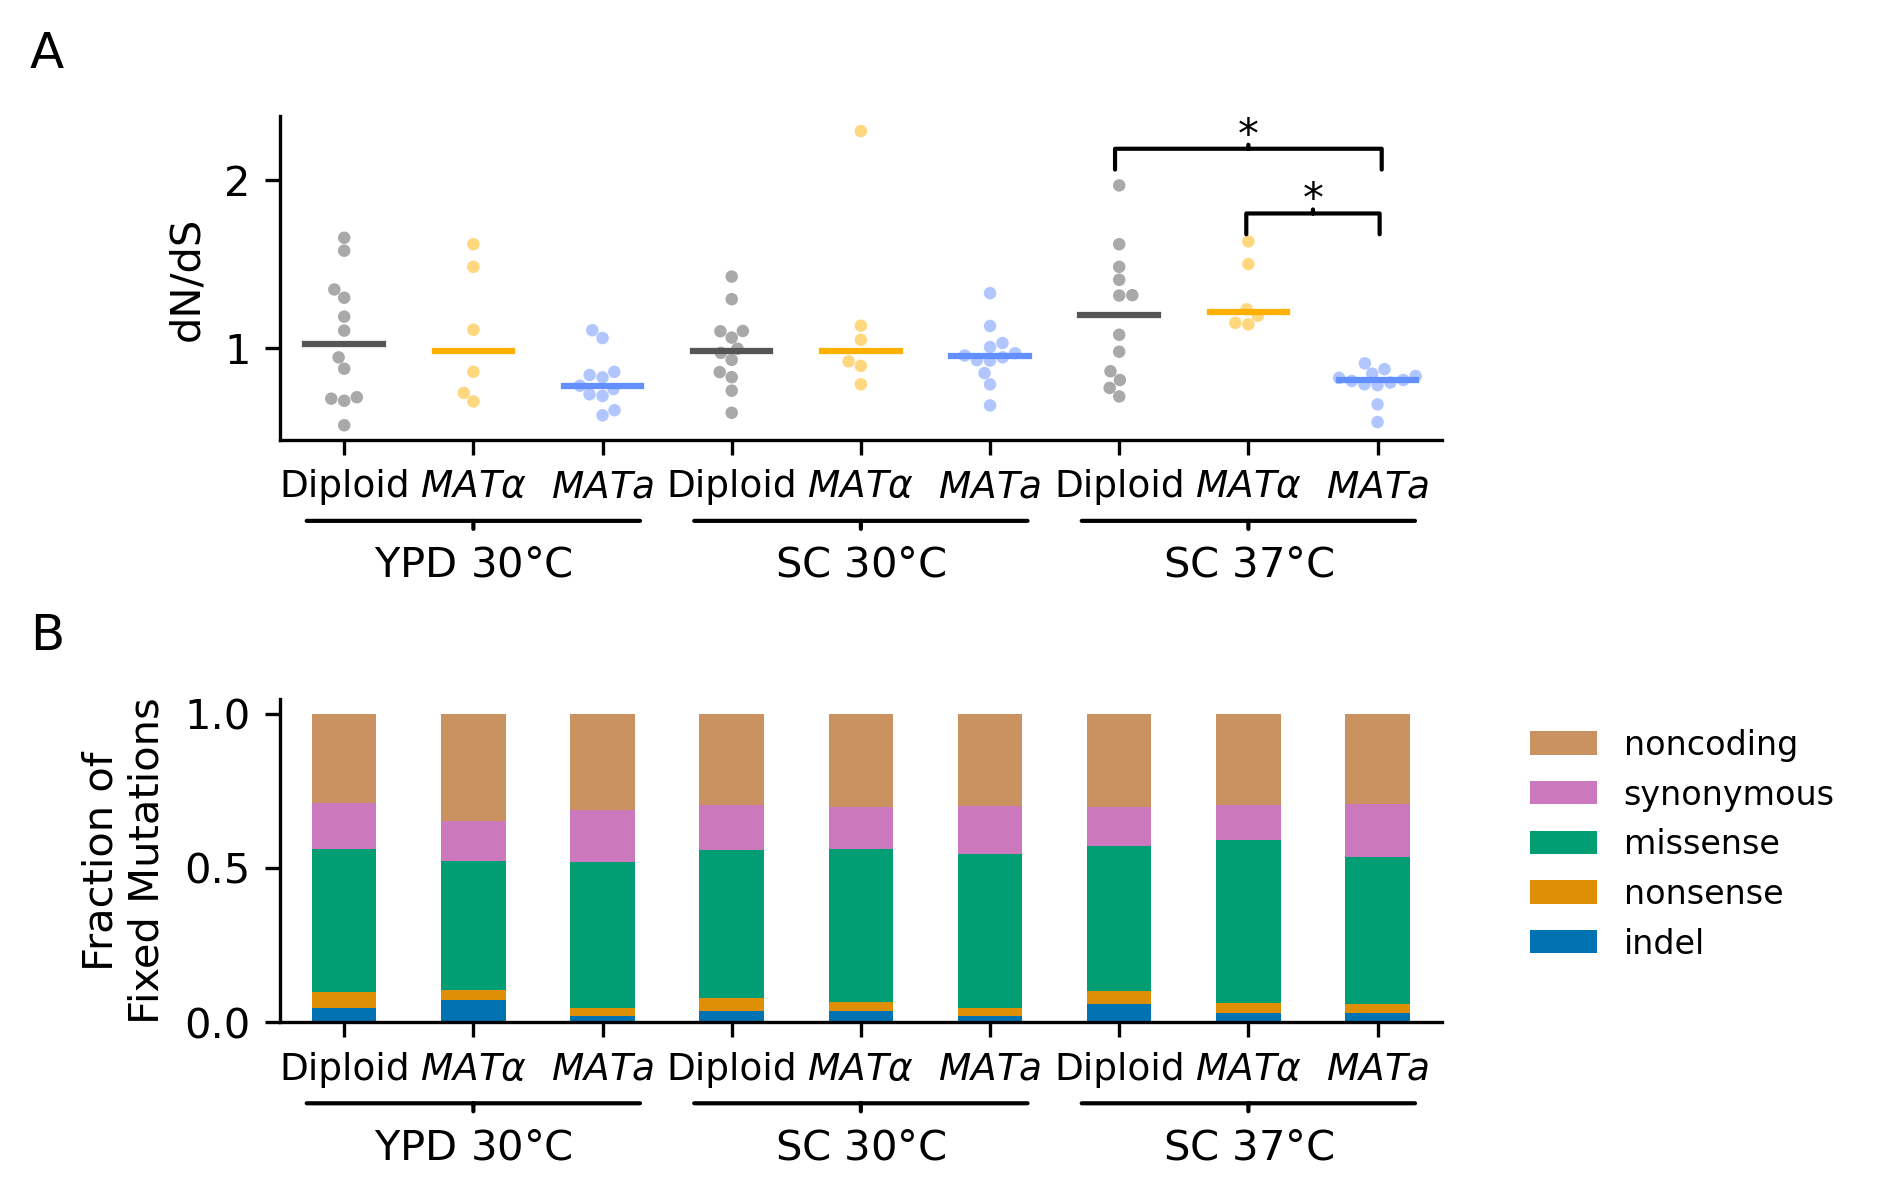

In [14]:
conditions = [strains_for_print[strain]+'\n'+plate2env[plate] for plate in plates for strain in strains]
use = well_muts_fixed[well_muts_fixed['Gene Set']=='All']
f, subs = pl.subplots(2, 1, figsize=(5,4), dpi=300)
pl.subplots_adjust(hspace=0.8)
boxplot_color_by_strain = {'diploid': '#777777', 'alpha': '#FFB000', 'a': '#648FFF'}
#sns.boxplot(x="Plate", y="dN/dS", hue='Strain', data=well_muts_fixed[well_muts_fixed['Gene Set']=='All'], ax=subs[0], hue_order=strains, palette=boxplot_color_by_strain, saturation=0.8, fliersize=3, linewidth=0.5)
sns.swarmplot(x="Condition", y="dN/dS", data=use, ax=subs[0], order=conditions, palette=[color_by_strain[s] for s in strains]*3, s=3, alpha=0.5)
for c in range(len(conditions)):
    med = np.median(use[use['Condition']==conditions[c]]['dN/dS'])
    subs[0].plot([c-0.3, c+0.3], [med, med], c=[color_by_strain[s] for s in strains][c%3])
    
subs[0].set_ylabel('dN/dS', fontsize=10)
subs[0].annotate('*', xy=((2*3+1.5)/9, 0.9), xytext=((2*3+1.5)/9, 1), xycoords='axes fraction', 
                fontsize=10, ha='center', va='top',
                arrowprops=dict(arrowstyle='-[, widthB=3.2, lengthB=0.5', lw=1.0))
subs[0].annotate('*', xy=((2*3+2)/9, 0.7), xytext=((2*3+2)/9, 0.8), xycoords='axes fraction', 
                fontsize=10, ha='center', va='top',
                arrowprops=dict(arrowstyle='-[, widthB=1.6, lengthB=0.5', lw=1.0))
mutation_breakdown_by_condition = use[['Condition'] + mutation_types_in_consequence_order].groupby('Condition').sum()
mutation_breakdown_by_condition['total'] = np.sum(mutation_breakdown_by_condition[mutation_types_in_consequence_order], axis=1)
for mt in mutation_types_in_consequence_order:
    mutation_breakdown_by_condition[mt] = mutation_breakdown_by_condition[mt]/mutation_breakdown_by_condition['total']
mutation_breakdown_by_condition['sort_column'] = mutation_breakdown_by_condition.apply(lambda r: conditions.index(r.name), axis=1)
mutation_breakdown_by_condition.sort_values(by='sort_column')[mutation_types_in_consequence_order].plot(kind='bar', stacked=True, ax=subs[1], color=cb_pal[:3]+cb_pal[4:6])
handles, labels = subs[1].get_legend_handles_labels()
subs[1].legend(handles[::-1], labels[::-1], frameon=False, bbox_to_anchor=(1.05, 1), fontsize=8)
subs[1].set_ylabel('Fraction of\nFixed Mutations',  fontsize=10)

for sub in subs:
    sub.set_xticklabels([i.split('\n')[0] for i in conditions], fontsize=9, rotation='horizontal')
    sub.set_xlabel('')
    for i in range(3):
        sub.annotate(plate2env[plates[i]], xy=((i*3+1.5)/9, -0.25), xytext=((i*3+1.5)/9, -0.45), xycoords='axes fraction', 
                fontsize=10, ha='center', va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB=4.0, lengthB=0', lw=1.0))
sns.despine()
subs[0].annotate('A', fontsize=12, xy=(-0.2, 1.15), xycoords="axes fraction", horizontalalignment="center")
subs[1].annotate('B', fontsize=12, xy=(-0.2, 1.15), xycoords="axes fraction", horizontalalignment="center")
f.savefig('../../FINAL_FIGURES/Fig4.pdf', background='transparent', bbox_inches='tight', pad_inches=0.1)

In [15]:
def plot_fixed_type_over_time(use_wells, sub, plate, fixed_by_str='fixed_by_'):
    muts_by_type = {gen: {m:0 for m in mutation_types_in_consequence_order} for gen in seq_gens}
    for well in use_wells:
        td = well_dats[well]
        for gen in seq_gens:
            for m in mutation_types_in_consequence_order:
                muts_by_type[gen][m] += len(set(td[(td['group_mutation_type']==m) & (td[fixed_by_str+str(gen)])]['mutation_group']))
    recs = [[muts_by_type[g][m] for g in seq_gens] for m in mutation_types_in_consequence_order]
    sub.stackplot([gen_fixer[g][plate] for g in seq_gens], recs, labels=mutation_types_in_consequence_order, colors=cb_pal[:3]+cb_pal[4:6])
    
supp = 3
for plate in plates:
    for strain_full in ['diploid', 'diploid_LOH', 'a', 'alpha']:
        strain = strain_full.split('_')[0]
        nrows = {'a': 4, 'diploid':4, 'alpha':2}[strain]
        f, subps = pl.subplots(nrows, 3, figsize=(7.25, 10*(nrows/6)), dpi=300, sharex=True, sharey=True)
        pl.subplots_adjust(hspace=0.5)
        #f.suptitle(plate2env[plate] + ' ' + strains_for_print[strain])
        subs = [subps[i][j] for i in range(nrows) for j in range(3)]
        wells_use = [w for w in all_wells if w[:2]==plate and well_to_strain[w]==strain]
        for i in range(len(wells_use)):
            if 'LOH' in strain_full:
                plot_fixed_type_over_time([wells_use[i]], subs[i], plate, fixed_by_str='LOH_fixed_by_')
            else:
                plot_fixed_type_over_time([wells_use[i]], subs[i], plate)
            subs[i].set_title(wells_use[i] + ': ' + strains_for_print[well_to_strain[wells_use[i]]] + ', ' + plate2env[plate], fontsize=10)
                
        handles, labels = subs[2].get_legend_handles_labels()
        subs[2].legend(handles[::-1], labels[::-1], frameon=False, bbox_to_anchor=(1.8, 1.1), fontsize=8)
        for i in range(3):
            subs[-1*i-1].set_xlabel('Generations')
        for j in range(nrows):
            if 'LOH' in strain_full:
                subs[j*3].set_ylabel('# Mutations\nFixed (LOH)')
            else:
                subs[j*3].set_ylabel('# Mutations\nFixed')
        sns.despine()
        f.savefig('../../FINAL_FIGURES/supp/Fig4Supp' + str(supp) + '_' + plate + '_' + strain_full + '_mutations.png', background='transparent', bbox_inches='tight', pad_inches=0.1)
        pl.close(f)
        supp += 1

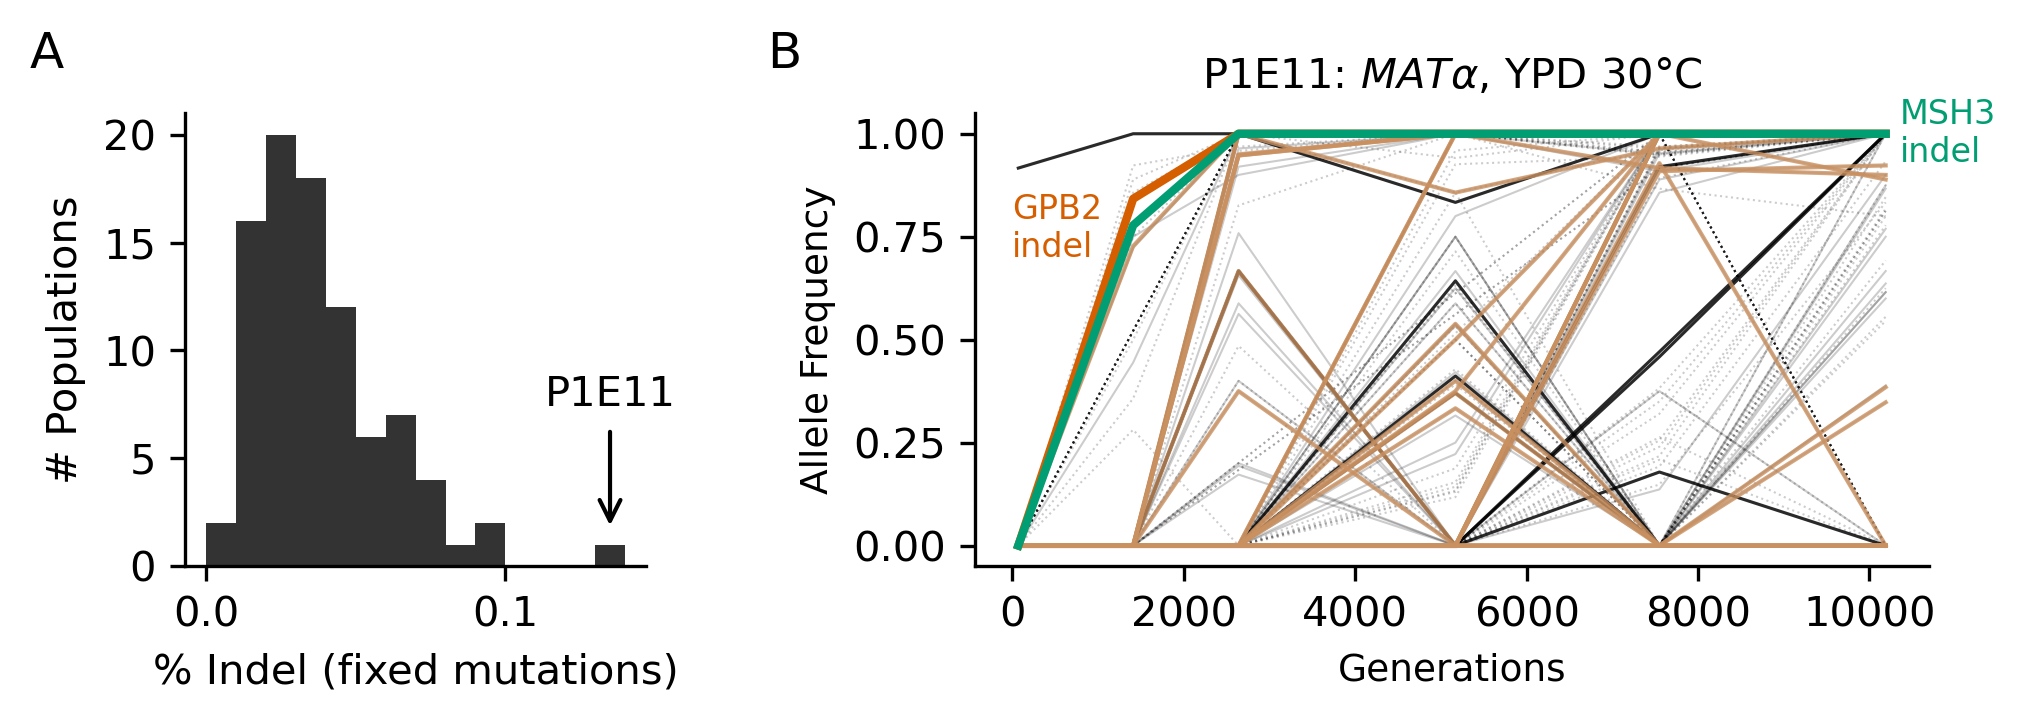

In [16]:
f = pl.figure(figsize=(7.5,2), dpi=300)
pl.subplots_adjust(wspace=0.5)
spec = gridspec.GridSpec(ncols=18, nrows=1, figure=f)
hist_sub = f.add_subplot(spec[0, :5])
af_sub = f.add_subplot(spec[0, 8:])
basic_traj_plot('P1E11', af_sub, 'P1', plot_ades=False)
#plot_trajectories(well_dats['P1E11'], af_sub, 'P1', opac=0.4, lw=0.5, ls=':')
plot_trajectories(well_dats['P1E11'], af_sub, 'P1', lw=1, ls='-', g_mutation_type='indel', colora=cb_pal[5])
plot_trajectories(well_dats['P1E11'], af_sub, 'P1', only_orfs=['YAL056W'], lw=2, colora=cb_pal[3], opac=1)
af_sub.annotate('GPB2\nindel', (0, 0.7), color=cb_pal[3], fontsize=8)
plot_trajectories(well_dats['P1E11'], af_sub, 'P1', only_orfs=['YCR092C'], lw=2, colora=cb_pal[2], opac=1)
af_sub.annotate('MSH3\nindel', (10350, 1), va='center', color=cb_pal[2], fontsize=8)
af_sub.set_xlabel('Generations', fontsize=9)
af_sub.set_ylabel('Allele Frequency', fontsize=9)
af_sub.set_title('P1E11' + ': ' + strains_for_print[well_to_strain['P1E11']] + ', ' + plate2env['P1'], fontsize=10)
hist_sub.hist(well_muts_fixed[well_muts_fixed['Gene Set']=='All']['percent_indel'], facecolor='#333333', bins=[i*0.01 for i in range(15)])
hist_sub.set_xlabel('% Indel (fixed mutations)')
hist_sub.set_ylabel('# Populations')
hist_sub.annotate('P1E11', xy=(0.135, 1.5), xytext=(0.135, 7), xycoords='data', 
                fontsize=10, ha='center', va='bottom',
                arrowprops=dict(arrowstyle='->'', head_length=0.5, head_width=0.25', lw=1.0))
sns.despine()
hist_sub.annotate('A', fontsize=12, xy=(-0.3, 1.1), xycoords="axes fraction", horizontalalignment="center")
af_sub.annotate('B', fontsize=12, xy=(-0.2, 1.1), xycoords="axes fraction", horizontalalignment="center")
f.savefig('../../FINAL_FIGURES/supp/Fig4Supp2.pdf', background='transparent', bbox_inches='tight', pad_inches=0.1)

## LOH figure

In [17]:
chromo_lens = {
    'chrI': 230218,
    'chrII': 813184,
    'chrIII': 316620,
    'chrIV': 1531933,
    'chrV': 576874,
    'chrVI': 270161,
    'chrVII': 1090940,
    'chrVIII': 562643,
    'chrIX': 439888,
    'chrX': 745751,
    'chrXI': 666816,
    'chrXII': 1078177,
    'chrXIII': 924431,
    'chrXIV': 784333,
    'chrXV': 1091291,
    'chrXVI': 948066,
}

centromere_locations = {
    'chrI': 151523.5,
    'chrII': 238265.0,
    'chrIII': 114443.0,
    'chrIV': 449766.0,
    'chrIX': 355687.0,
    'chrV': 152045.5,
    'chrVI': 148568.5,
    'chrVII': 496979.0,
    'chrVIII': 105644.5,
    'chrX': 436366.0,
    'chrXI': 440187.5,
    'chrXII': 150887.5,
    'chrXIII': 268090.0,
    'chrXIV': 628816.5,
    'chrXV': 326643.0,
    'chrXVI': 556015.0
}

chromos = ['chrI','chrII','chrIII','chrIV','chrV','chrVI','chrVII', 'chrVIII','chrIX', 'chrX','chrXI','chrXII',
           'chrXIII','chrXIV','chrXV','chrXVI']

# Alternate way of plotting LOH:

In [18]:
orf_hit_df['LOH_fraction'] = orf_hit_df['LOH']/orf_hit_df['dip_hits']
print('Out of', np.sum(orf_hit_df['dip_hits']), 'nonsyn. muts. fixed in diploids,', np.sum(orf_hit_df['LOH']), 'lost heterozygosity.')
prob_loh = np.sum(orf_hit_df['LOH'])/np.sum(orf_hit_df['dip_hits'])
orf_hit_df['p_LOH_by_chance'] = orf_hit_df.apply(lambda row: 1-sci_stats.binom.cdf(row['LOH']-1, row['dip_hits'], prob_loh), axis=1)
lot_of_loh = orf_hit_df[(orf_hit_df['p_LOH_by_chance']<0.05) & (orf_hit_df['dip_hits']>=6)][['Gene_ORF', 'CHROM', 'start', 'LOH', 'no_LOH', 'p_LOH_by_chance']]


Out of 2300 nonsyn. muts. fixed in diploids, 370 lost heterozygosity.


# Also setting up for a plot about Percent of hit in essential genes

In [19]:
gene_info['size'] = gene_info['end']-gene_info['start']
tmp = gene_info[['Essential_by_Liu2015', 'size']].groupby('Essential_by_Liu2015').sum().T
tmp['Fraction of coding genome that is in essential genes'] = tmp[True]/(tmp[True]+tmp[False])
tmp

Essential_by_Liu2015    False     True  \
size                  6892492  1361475   

Essential_by_Liu2015  Fraction of coding genome that is in essential genes  
size                                                           0.164948

In [20]:
orf_hit_df['haploid_low_impact'] = orf_hit_df['hap_hits'] - orf_hit_df['haploid_high_impact']
orf_hit_df['LOH_low_impact'] = orf_hit_df['LOH'] - orf_hit_df['LOH_high_impact']
orf_hit_df['no_LOH_low_impact'] = orf_hit_df['no_LOH'] - orf_hit_df['no_LOH_high_impact']
ess_breakdown=orf_hit_df[['Essential_by_Liu2015', 'haploid_low_impact', 'haploid_high_impact', 'LOH_low_impact', 'LOH_high_impact', 'no_LOH_low_impact', 'no_LOH_high_impact']].groupby('Essential_by_Liu2015').sum().T
ess_breakdown['percent_essential']=ess_breakdown[True]/(ess_breakdown[True]+ess_breakdown[False])
ess_breakdown['Fixed Mutation Type'] = ess_breakdown.apply(lambda row: {'haploid': 'Haploid', 'LOH': 'Diploid\nLOH', 'no': 'Diploid\nno LOH'}[row.name.split('_')[0]], axis=1)
ess_breakdown['Impact'] = ess_breakdown.apply(lambda row: {'high': 'High Impact', 'low': 'Moderate Impact'}[row.name.split('_')[-2]], axis=1)

In [21]:
ess_breakdown

Essential_by_Liu2015  False  True  percent_essential Fixed Mutation Type  \
haploid_low_impact     4571   899           0.164351             Haploid   
haploid_high_impact     510     8           0.015444             Haploid   
LOH_low_impact          253    43           0.145270        Diploid\nLOH   
LOH_high_impact          37     0           0.000000        Diploid\nLOH   
no_LOH_low_impact      1250   259           0.171637     Diploid\nno LOH   
no_LOH_high_impact      226    40           0.150376     Diploid\nno LOH   

Essential_by_Liu2015           Impact  
haploid_low_impact    Moderate Impact  
haploid_high_impact       High Impact  
LOH_low_impact        Moderate Impact  
LOH_high_impact           High Impact  
no_LOH_low_impact     Moderate Impact  
no_LOH_high_impact        High Impact

In [22]:
ess_breakdown['Total'] = ess_breakdown[True]+ess_breakdown[False]
new_mat = []
noness_fixations = {row.name: row[False] for jnk, row in ess_breakdown.iterrows()}
for way in ['haploid', 'LOH', 'no_LOH']:
    new_mat.append([{'haploid': 'Haploid', 'LOH': 'Diploid\nLOH', 'no_LOH': 'Diploid\nno LOH'}[way], noness_fixations[way+'_high_impact']/(noness_fixations[way+'_low_impact'])])
impact_breakdown = pd.DataFrame(new_mat, columns=['Fixed Mutation Type', 'High/Mod'])

# Plotting them together:

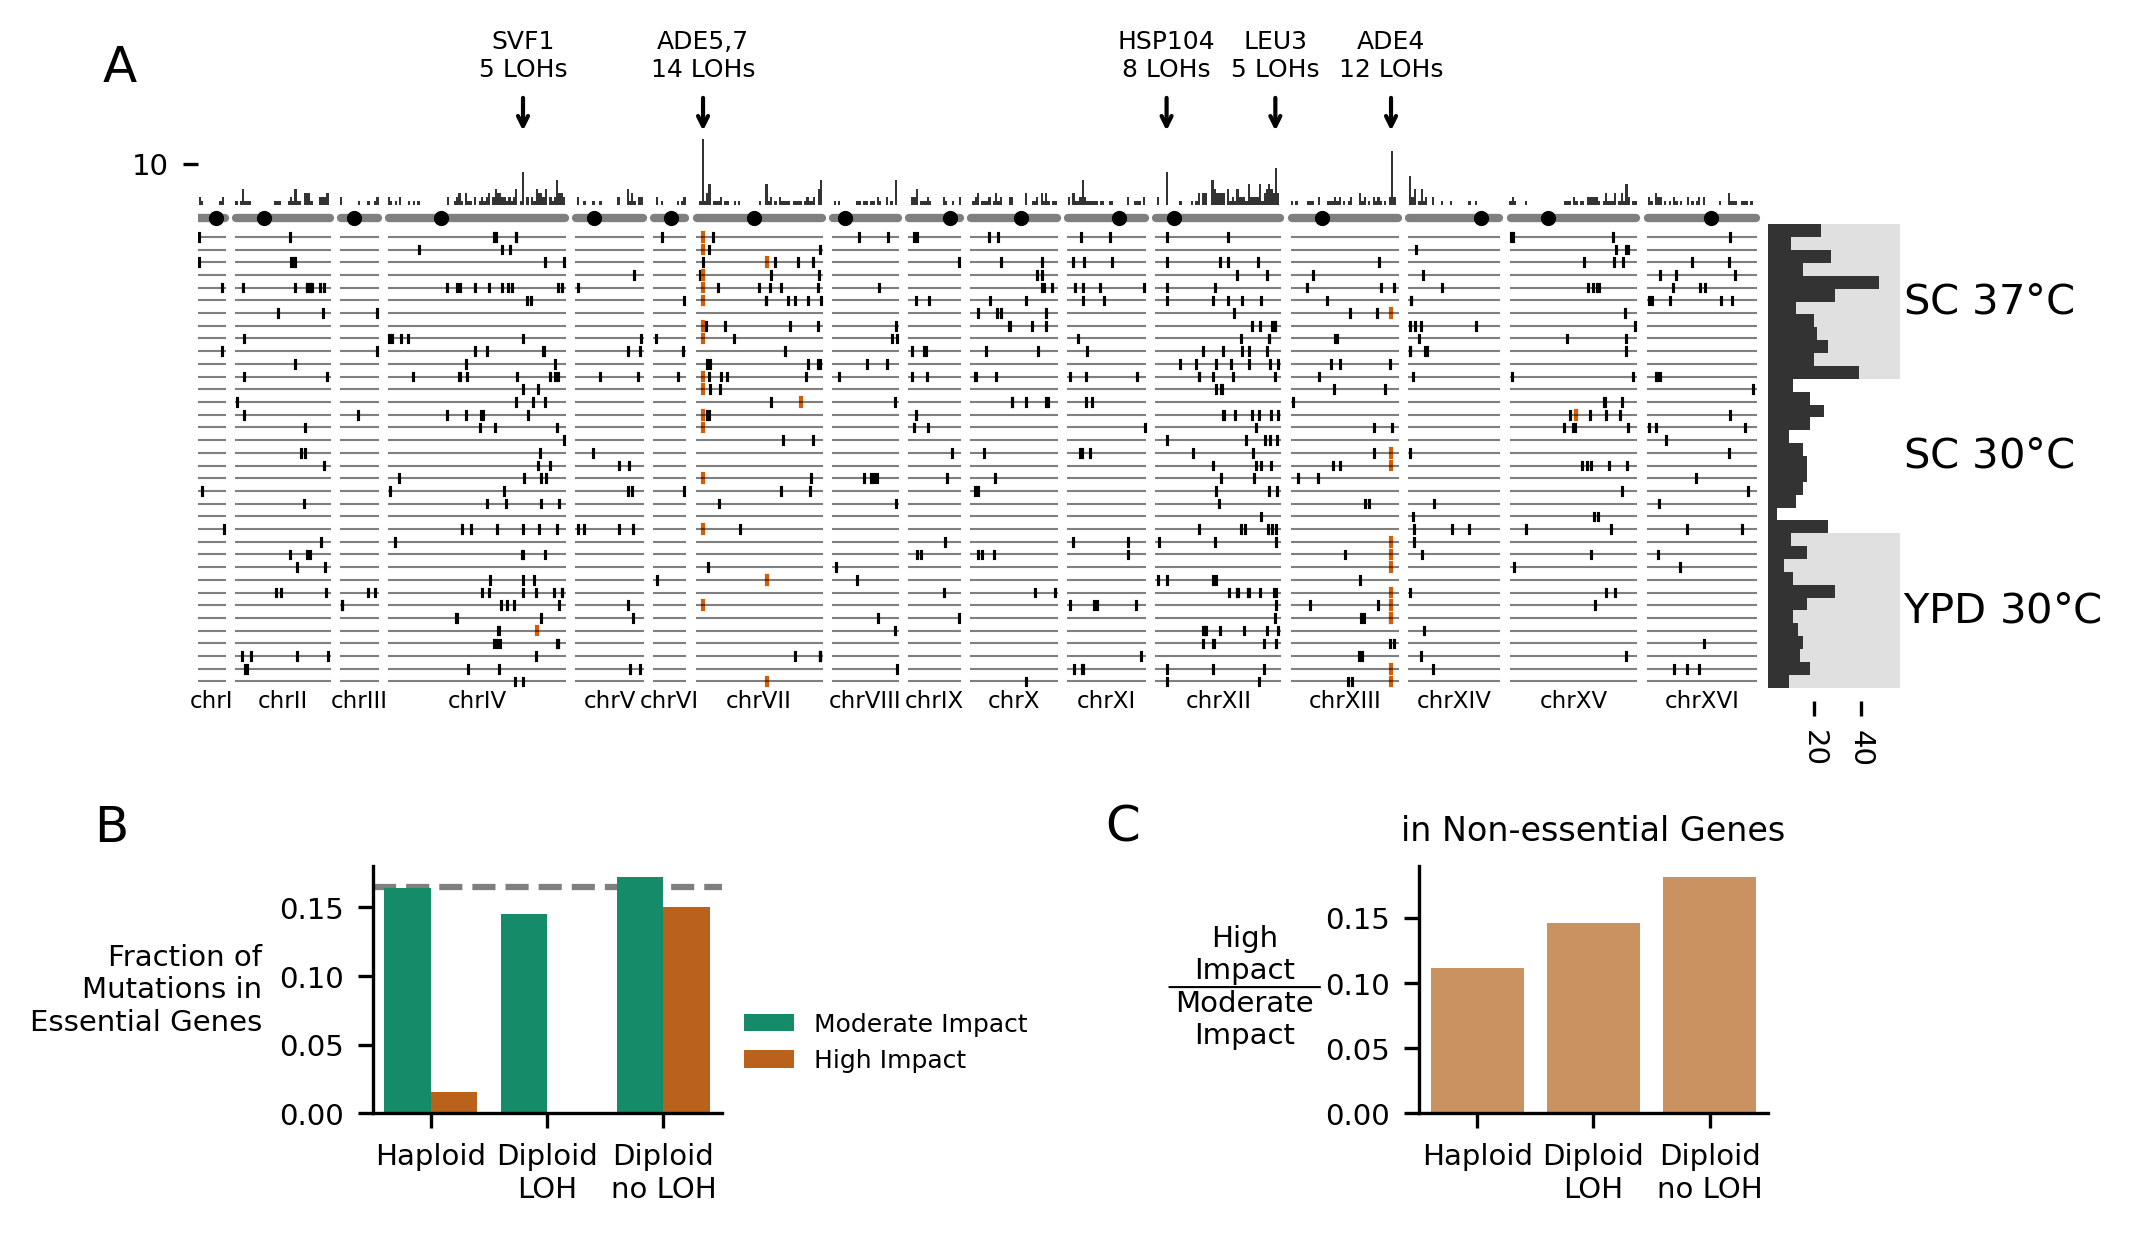

In [23]:
dipwells = [w for w in wells if well_to_strain[w]=='diploid']
f = pl.figure(figsize=(7.5, 7*(7.5/12)), dpi=300)
pl.subplots_adjust(wspace=0, hspace=0)
spec = gridspec.GridSpec(ncols=10, nrows=12, figure=f)
sub = f.add_subplot(spec[1:7, :9])
wc = 0
all_spots = []
all_well_spots = []
for well in dipwells:
    #sub.axhline(y=wc+0.5, c='k', alpha=0.3, lw=0.25)
    td = well_dats[well][(well_dats[well]['LOH_fixed_by_10150']) & (well_dats[well]['CHROM']!='chrMito')]
    mgs_seen = set()
    for entry in np.array(td[['CHROM', 'POS', 'ORF_hit', 'mutation_group']]):
        if entry[3] not in mgs_seen:
            mgs_seen.add(entry[3])
            running_len = np.sum([chromo_lens[c]+100000 for c in chromos[:chromos.index(entry[0])]])
            if entry[2] in ade_orfs:
                sub.plot([entry[1] + running_len,entry[1] + running_len], [wc+0.2, wc+0.8], c=ade_color, lw=1, zorder=1)
            else:
                sub.plot([entry[1] + running_len,entry[1] + running_len], [wc+0.2, wc+0.8], c='k', lw=0.75, zorder=0)
            all_spots.append(entry[1] + running_len)
            all_well_spots.append(wc)
    running_len = 0
    for chromo in chromos:
        sub.plot([running_len, running_len+chromo_lens[chromo]], [wc+0.5, wc+0.5], lw=0.5, c='k', alpha=0.5)
        running_len += chromo_lens[chromo]+100000
    wc += 1

top_hist = f.add_subplot(spec[:1, :9])
yts = [10]
top_hist.set_yticks(yts)
top_hist.set_yticklabels(yts, fontsize=9)
#top_hist.tick_params(axis=u'both', which=u'both',length=0)
#for yt in yts:
#    top_hist.axhline(y=yt, c='k', linestyle='dashed', alpha=0.5, lw=0.5)
top_hist.hist(all_spots, bins=running_len//20000, facecolor='#333333')
top_hist.set_xticks([])
top_hist.set_xlim([0,running_len])
top_hist.set_ylim([0,20])
for jnk, r in lot_of_loh.iterrows():
    running_len = np.sum([chromo_lens[c]+100000 for c in chromos[:chromos.index(r['CHROM'])]])
    top_hist.annotate(r['Gene_ORF'] + '\n'+str(r['LOH'])+ ' LOHs', xy=(running_len+r['start'], 16), xycoords='data', fontsize=6, ha='center', va='bottom',
                      xytext=(running_len+r['start'], 30), arrowprops=dict(arrowstyle='->', lw=1.0))

right_hist = f.add_subplot(spec[1:7, 9:])
yts = [20, 40]
right_hist.set_xticks(yts)
right_hist.set_xticklabels(yts, fontsize=9)
right_hist.add_patch(Rectangle((0, 0), 57, 12, fc='#E0E0E0', clip_on=False, zorder=-1))
right_hist.add_patch(Rectangle((0, 24), 57, 12, fc='#E0E0E0', clip_on=False, zorder=-1))
#right_hist.tick_params(axis=u'both', which=u'both',length=0, labeltop=True, labelbottom=False)
#for yt in yts:
#    right_hist.axvline(x=yt, c='k', linestyle='dashed', alpha=0.5, lw=0.5, zorder=0)
right_hist.hist(all_well_spots, bins=[i for i in range(len(dipwells)+1)], orientation='horizontal', facecolor='#333333', alpha=1, zorder=1)
right_hist.set_yticks([])
right_hist.set_ylim([-1,37.5])
for i in range(3):
    right_hist.annotate(plate2env[plates[i]], xy=(58, i*12+6), xycoords='data', fontsize=10, ha='left', va='center')
    
right_hist.set_xlim([0, 75])

top_hist.tick_params(axis='both', labelsize=7)
right_hist.tick_params(axis='both', labelsize=7, rotation=-90)

running_len = 0
for chromo in chromos:
    sub.annotate(chromo, xy=((running_len+chromo_lens[chromo]/2), -1), xycoords='data', horizontalalignment='center', verticalalignment='center', fontsize=5.5)
    sub.plot([running_len, running_len+chromo_lens[chromo]], [37, 37], lw=2, solid_capstyle='round', c='k', alpha=0.5)
    sub.scatter([(running_len+centromere_locations[chromo])], [37], c='k', s=7)
    running_len += chromo_lens[chromo]+100000
sub.set_ylim([-1,38])
sub.set_xlim([0,running_len])
sub.set_xticks([])
sub.set_yticks([])

ess_sub = f.add_subplot(spec[9:, 1:3])
ess_sub.axhline(y=0.165, c='k', linestyle='dashed', alpha=0.5, zorder=-1)
sns.barplot(data=ess_breakdown, x='Fixed Mutation Type', hue='Impact', palette=cb_pal[2:4], y='percent_essential', ax=ess_sub)
ess_sub.legend(bbox_to_anchor=(1, 0.5), frameon=False, fontsize=6)
ess_sub.tick_params(axis='both', labelsize=7)
ess_sub.set_ylabel('Fraction of\nMutations in\nEssential Genes', ha='right', rotation='horizontal', va='center', fontsize=7)
ess_sub.set_xlabel('')

impact_sub = f.add_subplot(spec[9:, 7:9])
#impact_sub.axhline(y=0.165, c='k', linestyle='dashed', alpha=0.5, zorder=-1)
sns.barplot(data=impact_breakdown, x='Fixed Mutation Type', y='High/Mod', facecolor=cb_pal[5], ax=impact_sub)
impact_sub.set_ylabel('')
impact_sub.annotate('', xy=(-0.74, 0.51), xytext=(-0.26, 0.51), xycoords='axes fraction', arrowprops=dict(arrowstyle='-', lw=0.5)) #division line hack
impact_sub.annotate('High\nImpact\nModerate\nImpact', fontsize=7, ha='center', va='center', xy=(-0.7, 0.51), xytext=(-0.5, 0.51), xycoords='axes fraction') #division line hack
impact_sub.set_xlabel('')
impact_sub.set_title('in Non-essential Genes', fontsize=8)
impact_sub.tick_params(axis='both', labelsize=7)

sns.despine(left=True, bottom=True, ax=sub)
sns.despine(left=True, bottom=True, ax=right_hist)
sns.despine(left=True, bottom=True, ax=top_hist)
sns.despine(ax=ess_sub)
sns.despine(ax=impact_sub)

top_hist.annotate('A', fontsize=12, xy=(-0.05, 1.5), xycoords="axes fraction", horizontalalignment="center")
ess_sub.annotate('B', fontsize=12, xy=(-0.75, 1.1), xycoords="axes fraction", horizontalalignment="center")
impact_sub.annotate('C', fontsize=12, xy=(-0.85, 1.1), xycoords="axes fraction", horizontalalignment="center")

f.savefig('../../FINAL_FIGURES/Fig8.pdf', background='transparent', bbox_inches='tight', pad_inches=0.1)

# Parallelism

In [24]:
go_res = pd.read_csv('../../Output/WGS/combined_option/GO_enrichments.tsv', delimiter='\t')
go_res[go_res['pval_benjamini_hochberg']<0.05]

GO ID                                            GO term  \
0  GO:0043087                      regulation of GTPase activity   
1  GO:0010525          regulation of transposition, RNA-mediated   
2  GO:0007165                                signal transduction   
3  GO:0046580  negative regulation of Ras protein signal tran...   
4  GO:0001403  invasive growth in response to glucose limitation   
5  GO:0007124                                pseudohyphal growth   
6  GO:0006189                 'de novo' IMP biosynthetic process   
7  GO:0006075          (1->3)-beta-D-glucan biosynthetic process   
8  GO:0006164             purine nucleotide biosynthetic process   

   pval_uncorrected  pval_benjamini_hochberg  num_hits  num_in_group  \
0      3.675255e-08                 0.000110         6             9   
1      8.857550e-06                 0.011370         4             6   
2      1.179807e-05                 0.011370        10            65   
3      2.021107e-05                 0.011370         4             7   
4      2.168675e-05                 0.011370         8            43   
5      2.272413e-05                 0.011370         9            56   
6      6.958475e-05                 0.029842         4             9   
7      8.697378e-05                 0.032637         3             4   
8      1.083569e-04                 0.036143         5            18   

                                                hits  
0                  IQG1;IRA2;TRS120;RGA2;TRS130;IRA1  
1                               STE4;STE5;STE7;STE11  
2  GPB1;IQG1;IRA2;BEM2;CYR1;STE4;GPB2;RGA2;COS111...  
3                                GPB1;IRA1;GPB2;IRA2  
4         GPB1;STE5;STE4;GPB2;STE11;STE12;FLO11;STE7  
5   GPB1;CDC39;GPB2;STE11;STE12;FLO11;PDA1;STE7;MDS3  
6                              ADE5,7;ADE4;ADE2;ADE6  
7                                     GSC2;FKS1;FKS3  
8                         ADE5,7;ADE3;ADE2;ADE4;ADE6

In [25]:
named_groupings = {
    'Purine biosynthesis': ['ADE4', 'ADE5,7', 'ADE3', 'ADE8', 'ADE6', 'ADE2'],
    'Sterility genes': ['STE12', 'STE11', 'STE7', 'STE5', 'STE4'],
    'Negative regulation of Ras pathway': ['GPB2', 'GPB1', 'IRA2', 'IRA1'],
    #'beta-D-glucan biosynthesis': ['HKR1', 'GSC2', 'FKS1', 'FKS3']
}

all_in_groups = []
for g in named_groupings:
    all_in_groups += named_groupings[g]
    
named_groupings['Other'] = [g for g in orf_hit_df[orf_hit_df['pops_hit']>=10].sort_values('num_hits', ascending=False)['Gene_ORF'] if g not in all_in_groups]

groups_list = [g for g in named_groupings]
gene_lists = [named_groupings[g] for g in groups_list]
all_of_em = []
for g in gene_lists:
    all_of_em += g
    
# this gives alpha wells, then a wells, then diploid wells for each plate
ws = sorted(wells, key=lambda w: w[:2] + str(int(w[3:]) % 11).zfill(2) + w[3])

def get_genehit_map(gene_list, wells_use):
    bigmat = []
    for g in gene_list:
        tmp = []
        trow = orf_hit_df[orf_hit_df['Gene_ORF']==g].iloc[0]
        for well in wells_use:
            if g == 'ADE2' and (well in wells_w_ade2_stop_lost):
                tmp.append(-1)
            else:
                tmp.append(trow[well])
        bigmat.append(tmp)
    return bigmat

In [26]:
orf_hit_df = orf_hit_df.merge(multi_hit_df[['ORF', 'dependent_on']], how='left')

In [27]:
def get_dep(x):
    if pd.isnull(x):
        return '-'
    elif x == 'strain':
        return 'S'
    elif x == 'environment':
        return 'E'
    elif x == 'both':
        return 'SxE'
    else:
        print('unknown dependent_on:', x)
        
def perc_loh(r):
    hit_string = str(r['no_LOH'] + r['LOH'])
    return str(r['LOH']) + ' / ' + hit_string
    
def perc_high(r):
    hit_string = str(r['num_hits'])
    return str(r['high_impact']) + ' / ' + hit_string

def perc_loh_num(r):
    if (r['no_LOH'] + r['LOH']) > 0:
        return r['LOH'] / (r['no_LOH'] + r['LOH'])
    else:
        return -1
    
def perc_high_num(r):
    if r['num_hits'] > 0:
        return r['high_impact']/r['num_hits']
    else:
        return -1

def gene_ess(row):
    if pd.notnull(row['Essential_by_Liu2015']) and row['Essential_by_Liu2015']: 
        return '** ' + row['Gene_ORF']
    elif pd.notnull(row['Essential_by_Giaever2002']) and row['Essential_by_Giaever2002']:
        return '* ' + row['Gene_ORF']
    else:
        return row['Gene_ORF']

orf_hit_df['dep'] = orf_hit_df['dependent_on'].apply(lambda x: get_dep(x))
orf_hit_df['gene_ess'] = orf_hit_df.apply(lambda x: gene_ess(x), axis=1)
#orf_hit_df['mult'] = orf_hit_df['multiplicity'].apply(lambda x: int(x))
orf_hit_df['frac_LOH'] = orf_hit_df.apply(lambda r: perc_loh(r), axis=1)
orf_hit_df['frac_high'] = orf_hit_df.apply(lambda r: perc_high(r), axis=1)
orf_hit_df['frac_LOH_num'] = orf_hit_df.apply(lambda r: perc_loh_num(r), axis=1)
orf_hit_df['frac_high_num'] = orf_hit_df.apply(lambda r: perc_high_num(r), axis=1)

In [28]:
orf_hit_df.to_csv('../../Output/WGS/combined_option/all_mutations_plus.tsv', sep='\t', index=False)

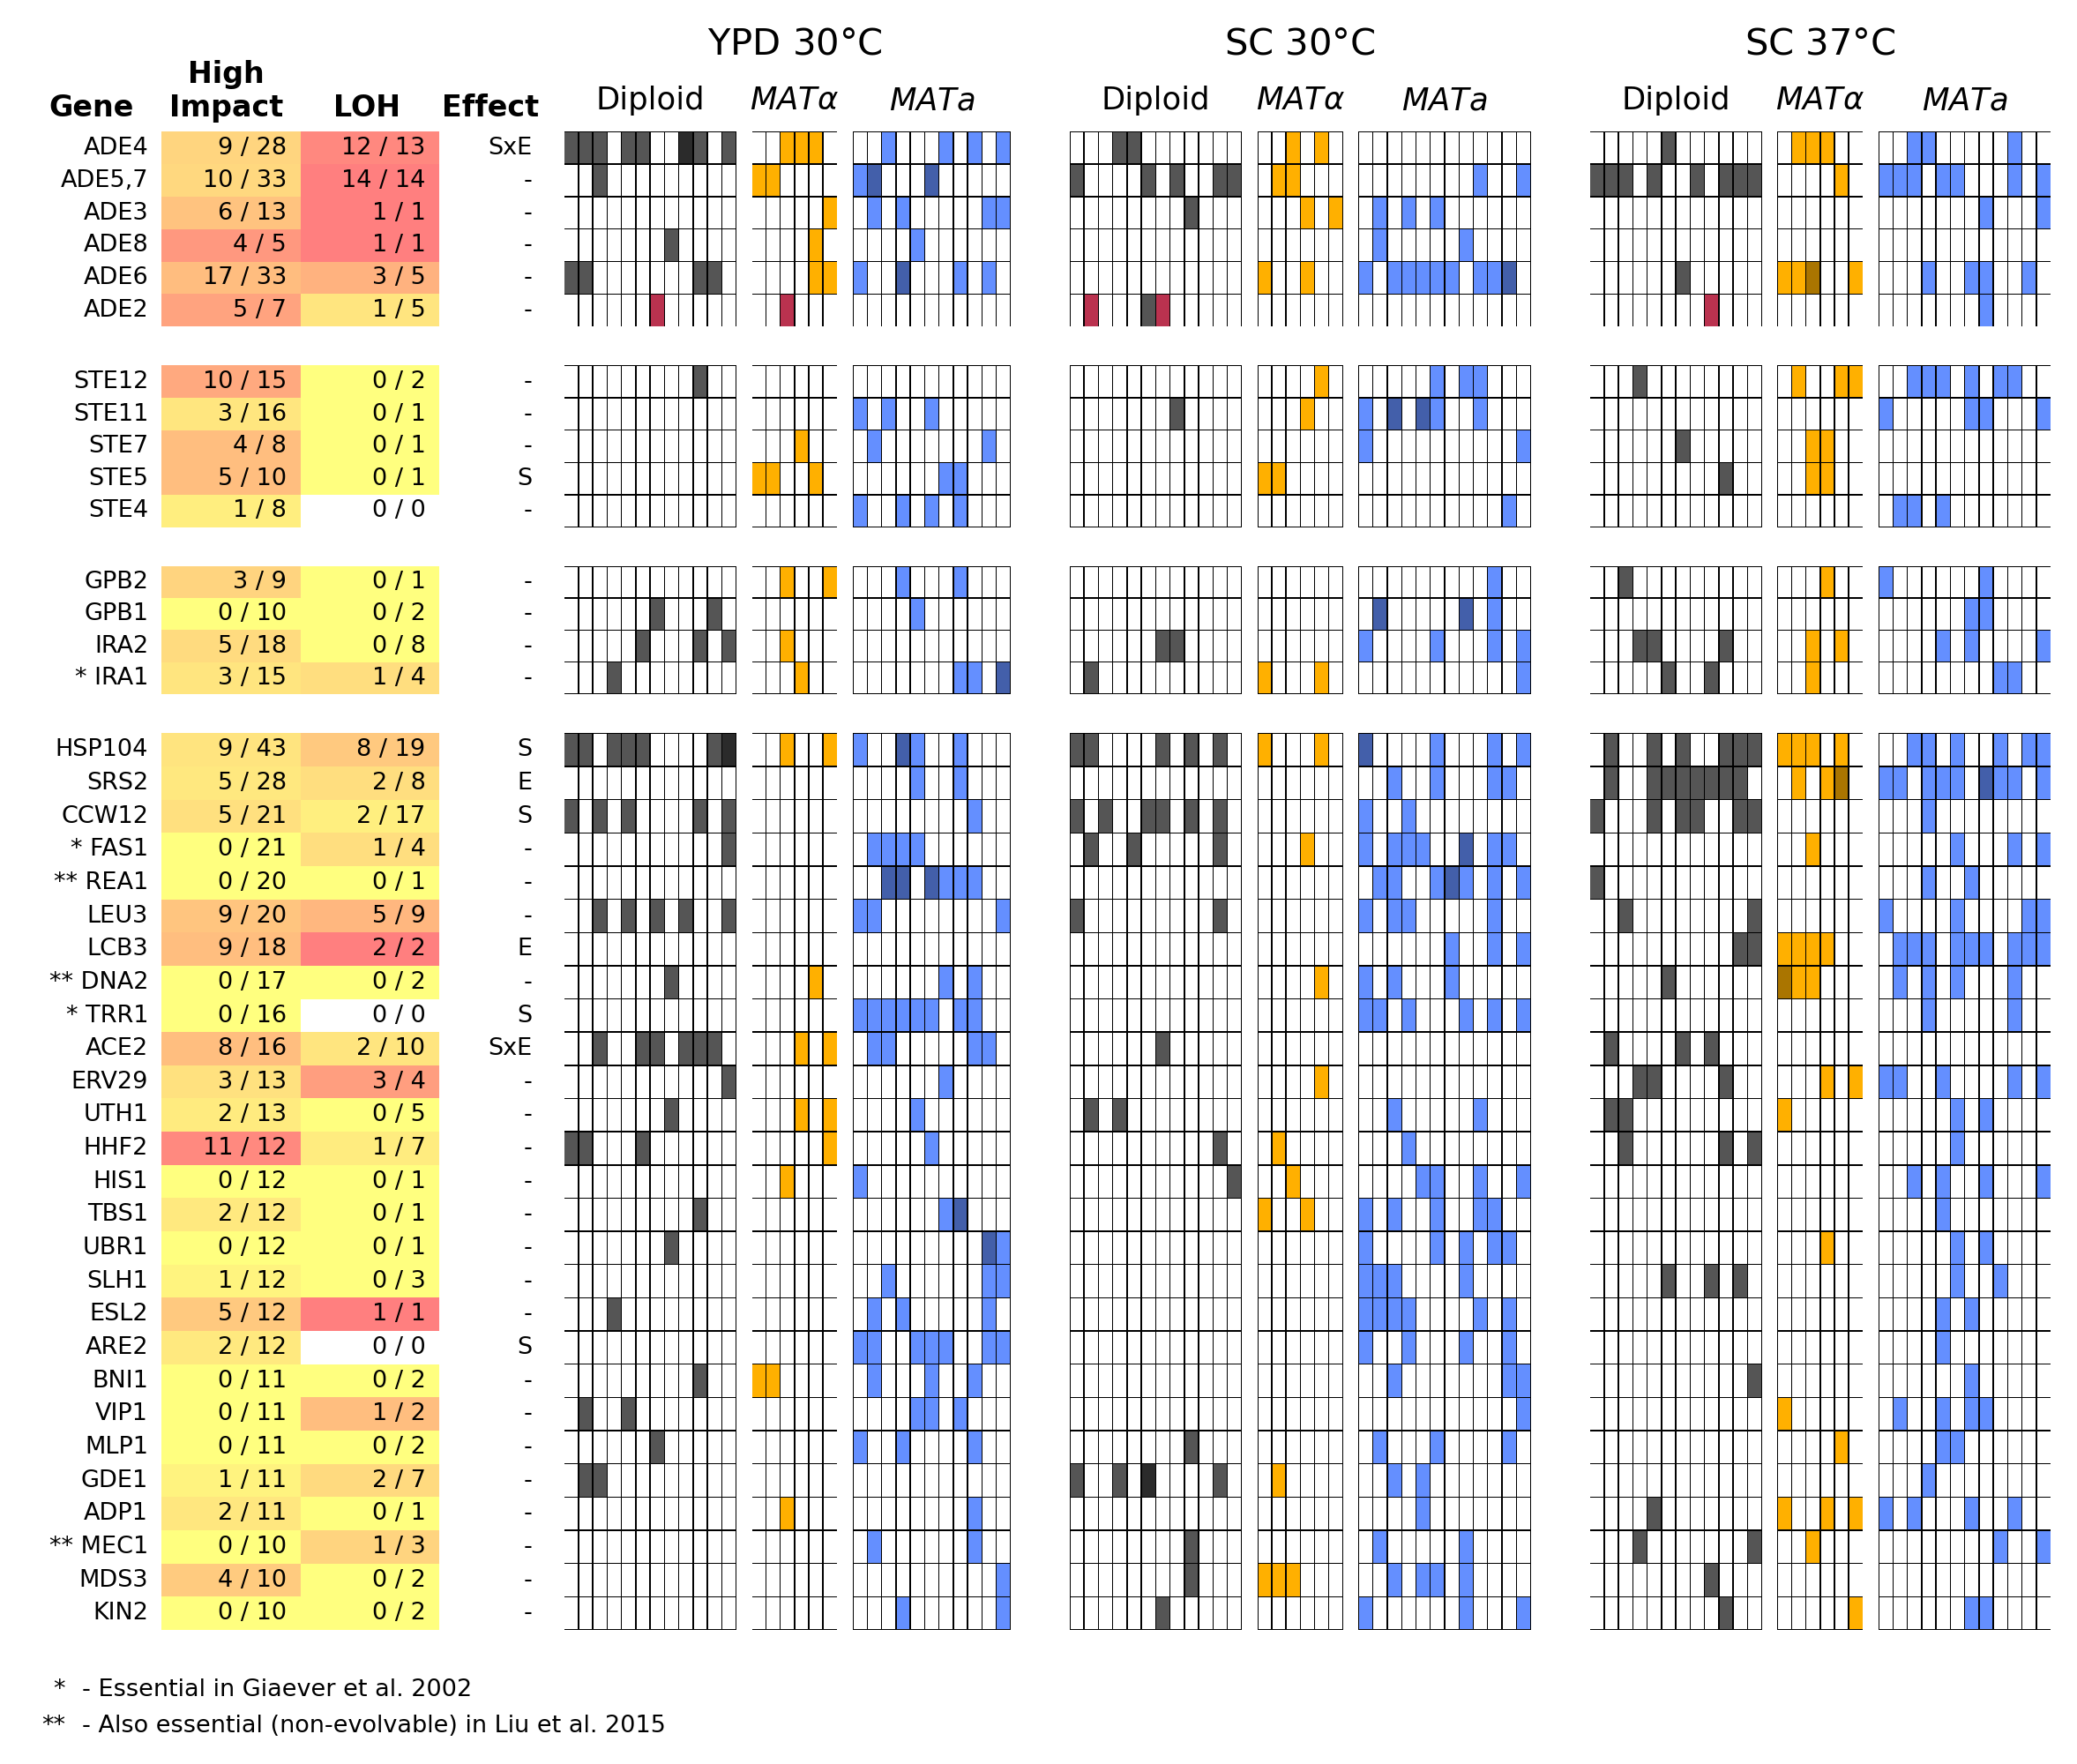

In [29]:
colorscale = pl.get_cmap('autumn_r')
#colorscale = {i: (vcmap.colors[i][0], vcmap.colors[i][1], vcmap.colors[i][2], 0.5) for i in range(len(vcmap.colors))}
#colorscale[-255] = 'w'

f = pl.figure(figsize=(7.25,7.5), dpi=300)
pl.subplots_adjust(wspace=0.1)
gap = 1
wgaps = {'a': 4, 'alpha': 1, 'diploid': 1}
gs0 = gridspec.GridSpec(len(all_of_em)+(len(groups_list)-1)*gap, len(wells)+wgaps['diploid']*6+wgaps['a']*2)
gs = []
running_num = 0

info_columns = [('Gene', 'gene_ess', False), ('Fraction\nLikely LOF', 'frac_high', 'frac_high_num'), ('Fraction LOH\n(diploid)', 'frac_LOH', 'frac_LOH_num'), ('dep', 'dep', False)]
gl_c = 0
for genes in gene_lists:
    # Making graph
    running_w = 0
    gl_c += 1
    for p in range(3):
        for strain in strains:
            strain_col = to_rgba(color_by_strain[strain])
            if strain == 'diploid':
                strain_col_darker = (strain_col[0]-strain_col[0]/2, strain_col[1]-strain_col[1]/2, strain_col[2]-strain_col[2]/2, 1)
            else:
                strain_col_darker = (strain_col[0]-strain_col[0]/3, strain_col[1]-strain_col[1]/3, strain_col[2]-strain_col[2]/3, 1)
            custom_cmap = ListedColormap(['#BA324F', 'w', strain_col, strain_col_darker])
            wells_use = [w for w in ws if w[:2]==plates[p] and well_to_strain[w]==strain]
            tmp_gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[running_num:running_num+len(genes),running_w:running_w+len(wells_use)])
            sub = pl.Subplot(f, tmp_gs[0])
            f.add_subplot(sub)
            if running_w == 0:
                # Making table
                if running_num == 0:
                    top = 1.08
                    sub.annotate('Gene', xy=(-3.125+0.75/2, top), fontsize=8, xycoords='axes fraction', horizontalalignment='center', weight='bold')
                    sub.annotate('High\nImpact', xy=(-3.125+0.75+0.82/2, top), fontsize=8, xycoords='axes fraction', horizontalalignment='center', weight='bold')
                    sub.annotate('LOH', xy=(-3.125+0.75+0.82+0.82/2, top), fontsize=8, xycoords='axes fraction', horizontalalignment='center', weight='bold')
                    sub.annotate('Effect', xy=(-3.125+0.75+0.82+0.82+0.61/2, top), fontsize=8, xycoords='axes fraction', horizontalalignment='center', weight='bold')
                if gl_c == len(gene_lists):
                    sub.annotate('*', xy=(-2.9, -0.08), ha='right', va='bottom', xycoords="axes fraction", clip_on=False, fontsize=6.5)
                    sub.annotate('**', xy=(-2.9, -0.12), ha='right', va='bottom', xycoords="axes fraction", clip_on=False, fontsize=6.5)
                    sub.annotate('- Essential in Giaever et al. 2002', xy=(-2.8, -0.08), va='bottom', 
                                 xycoords="axes fraction", clip_on=False, fontsize=6.5)
                    sub.annotate('- Also essential (non-evolvable) in Liu et al. 2015', xy=(-2.8, -0.12), va='bottom', 
                                 xycoords="axes fraction", clip_on=False, fontsize=6.5)
                tmp_df = orf_hit_df[orf_hit_df['Gene_ORF'].isin(genes)]
                tmp_df['sorter'] = tmp_df['Gene_ORF'].apply(lambda g: genes.index(g))
                tmp_df = tmp_df.sort_values(by='sorter')
                cell_colors = []
                for jnk, entry in tmp_df.iterrows():
                    tmprow = []
                    for i in info_columns:
                        if i[2] in entry:
                            if entry[i[2]] == -1:
                                tmprow.append('w')
                            else:
                                tmpcolor = colorscale(entry[i[2]])
                                tmprow.append((tmpcolor[0], tmpcolor[1], tmpcolor[2], 0.5))
                        else:
                            tmprow.append('w')
                    cell_colors.append(tmprow)
                tmp_table = sub.table(cellText=tmp_df.as_matrix([i[1] for i in info_columns]), bbox=[-3.125, 0, 3, 1], colWidths=[0.8, 0.82, 0.82, 0.61], cellColours=cell_colors)
                tmp_table.auto_set_font_size(False)
                tmp_table.set_fontsize(6.5)
                for key, cell in tmp_table.get_celld().items():
                    cell.set_linewidth(0)
                
                    
            ghmap = np.array(get_genehit_map(genes, wells_use))
            sns.heatmap(np.clip(ghmap, -1, 2), ax=sub, cmap=custom_cmap, cbar=False, linewidths=0.1, linecolor='k', vmin=-1, vmax=2)
            if running_num == 0: # top of graph
                sub.set_title(strains_for_print[strain], fontsize=8.5)
                if strain == 'alpha':
                    sub.annotate(plate2env[plates[p]], xy=(0.5, 1.4), fontsize=10, xycoords='axes fraction', horizontalalignment='center')
            sub.set_xticks([])
            sub.set_yticks([])
            sub.tick_params(which='both', axis='both', length=0, labelbottom=False, labeltop=False)
            running_w += len(wells_use) + wgaps[strain]
    running_num += len(genes)+gap
    
f.savefig('../../FINAL_FIGURES/Fig6.pdf', background='transparent', bbox_inches='tight', pad_inches=0.1)

# Supp figs, all the rest:

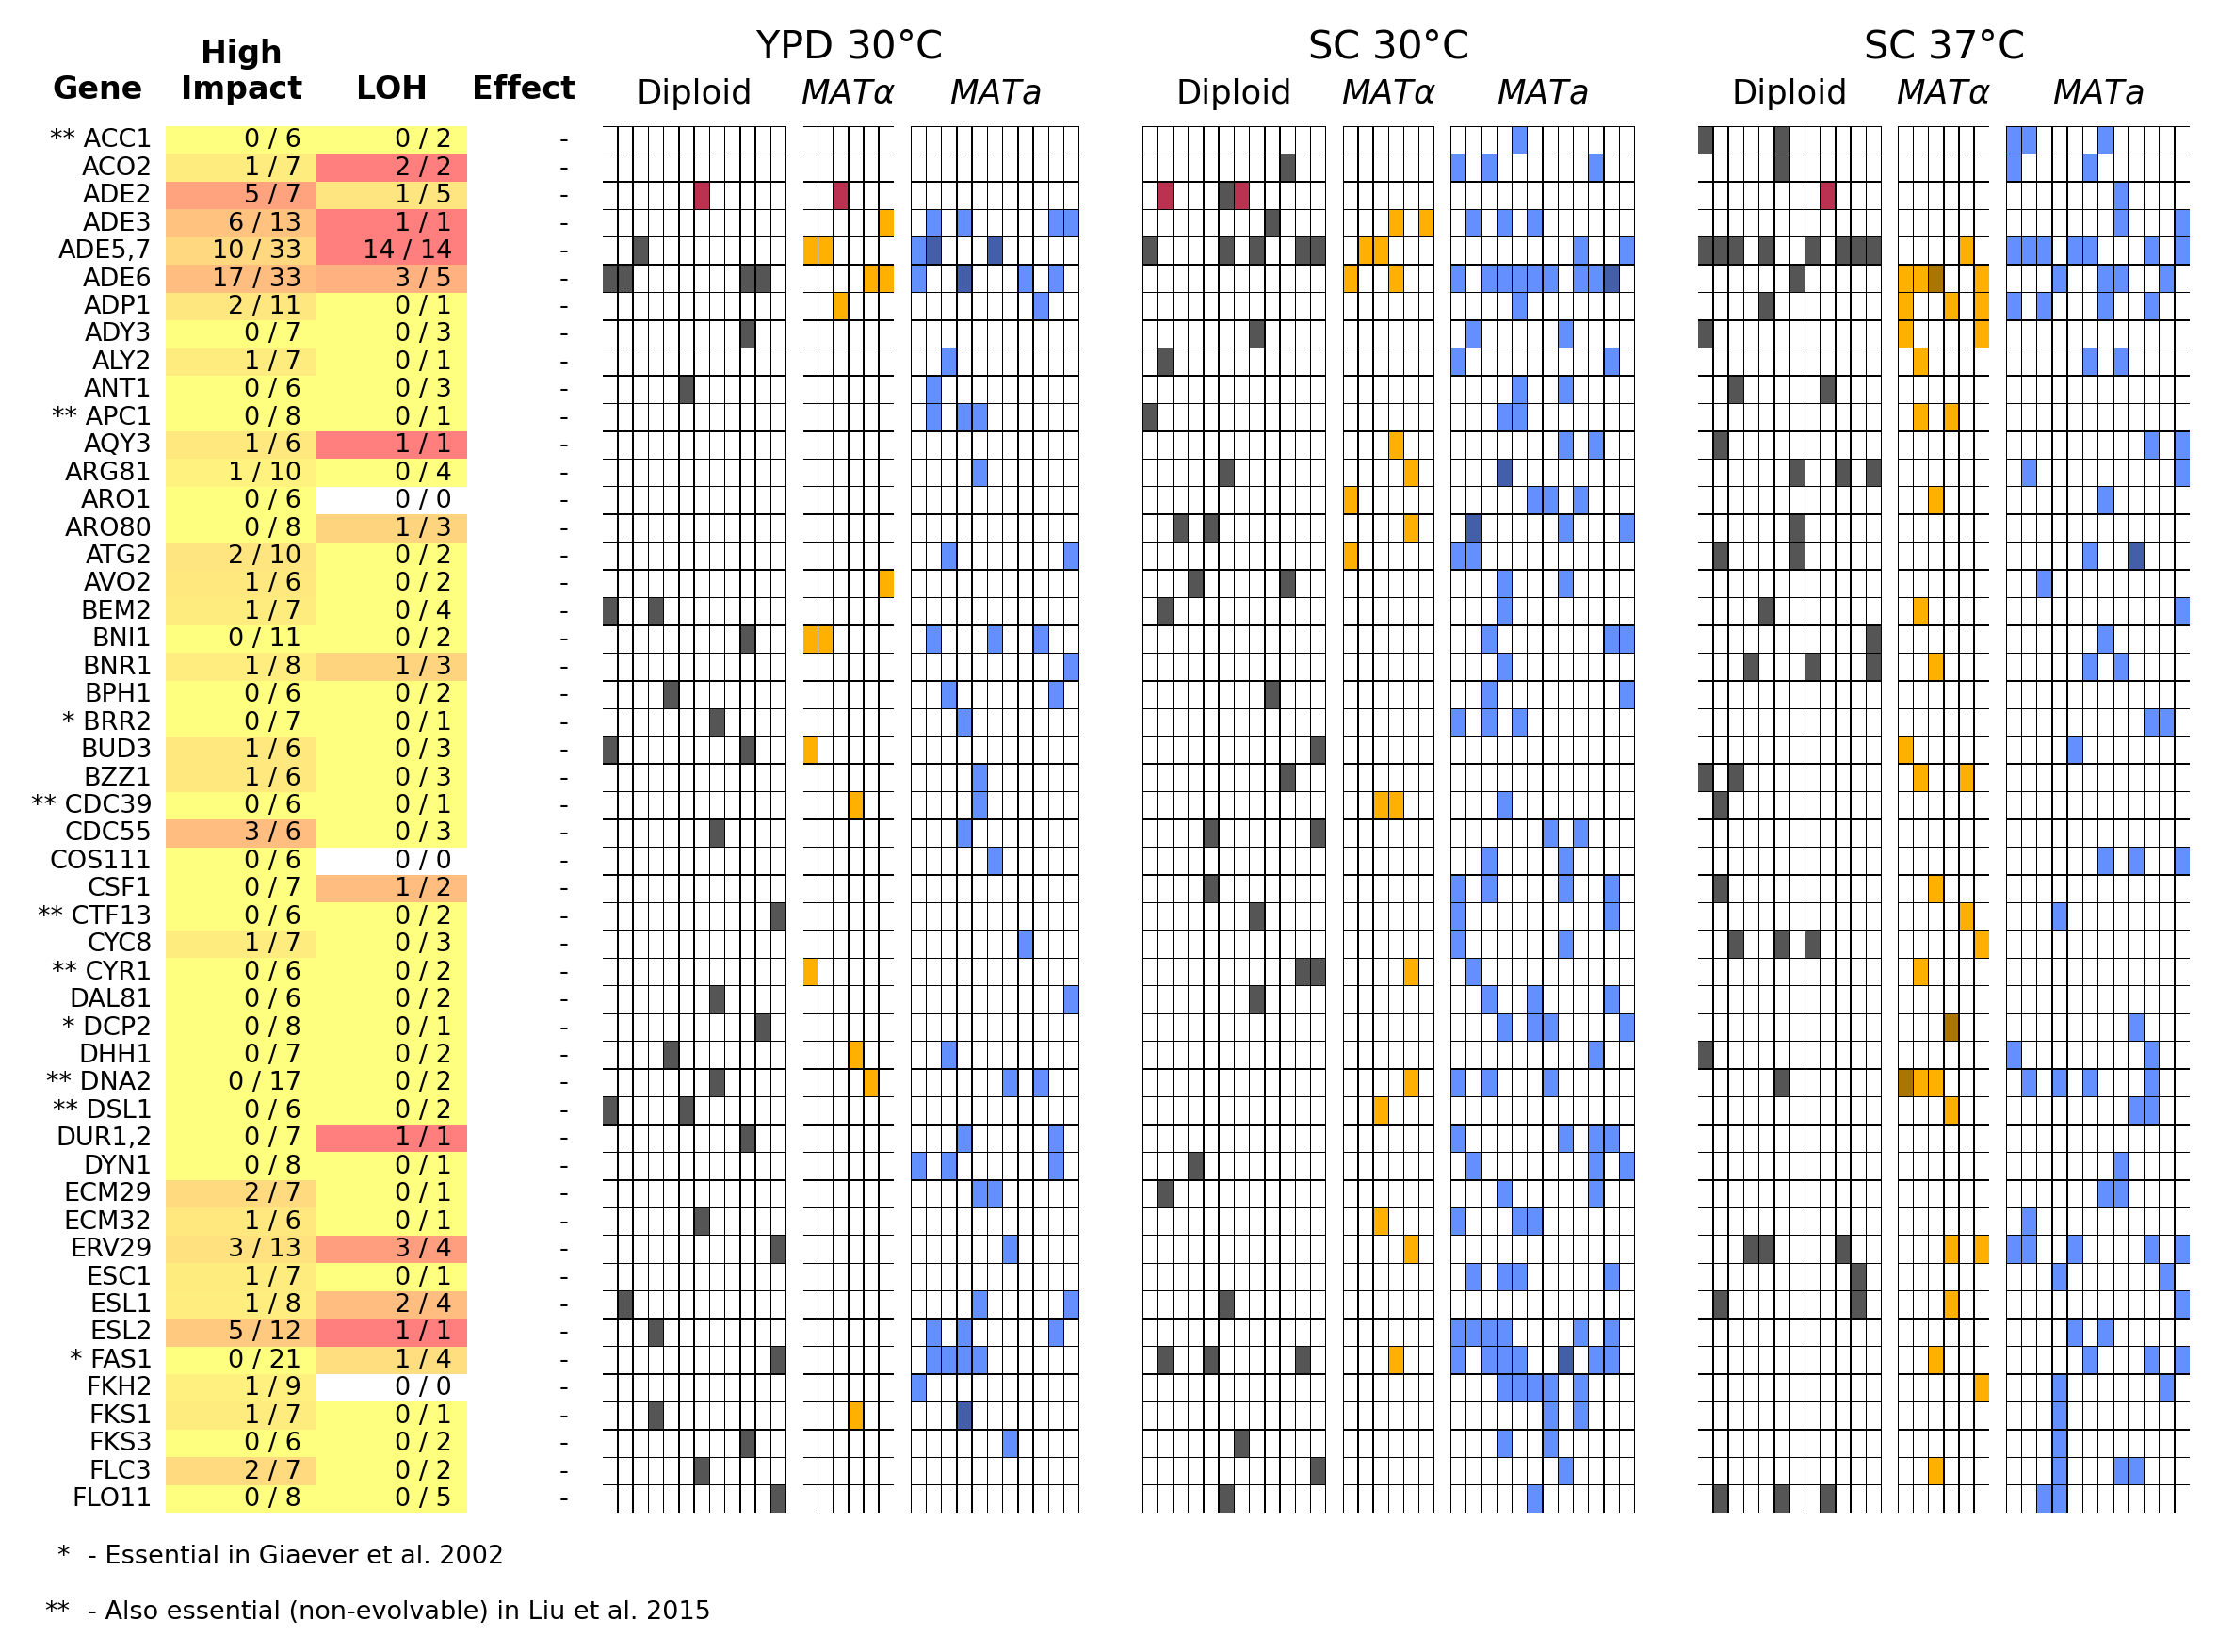

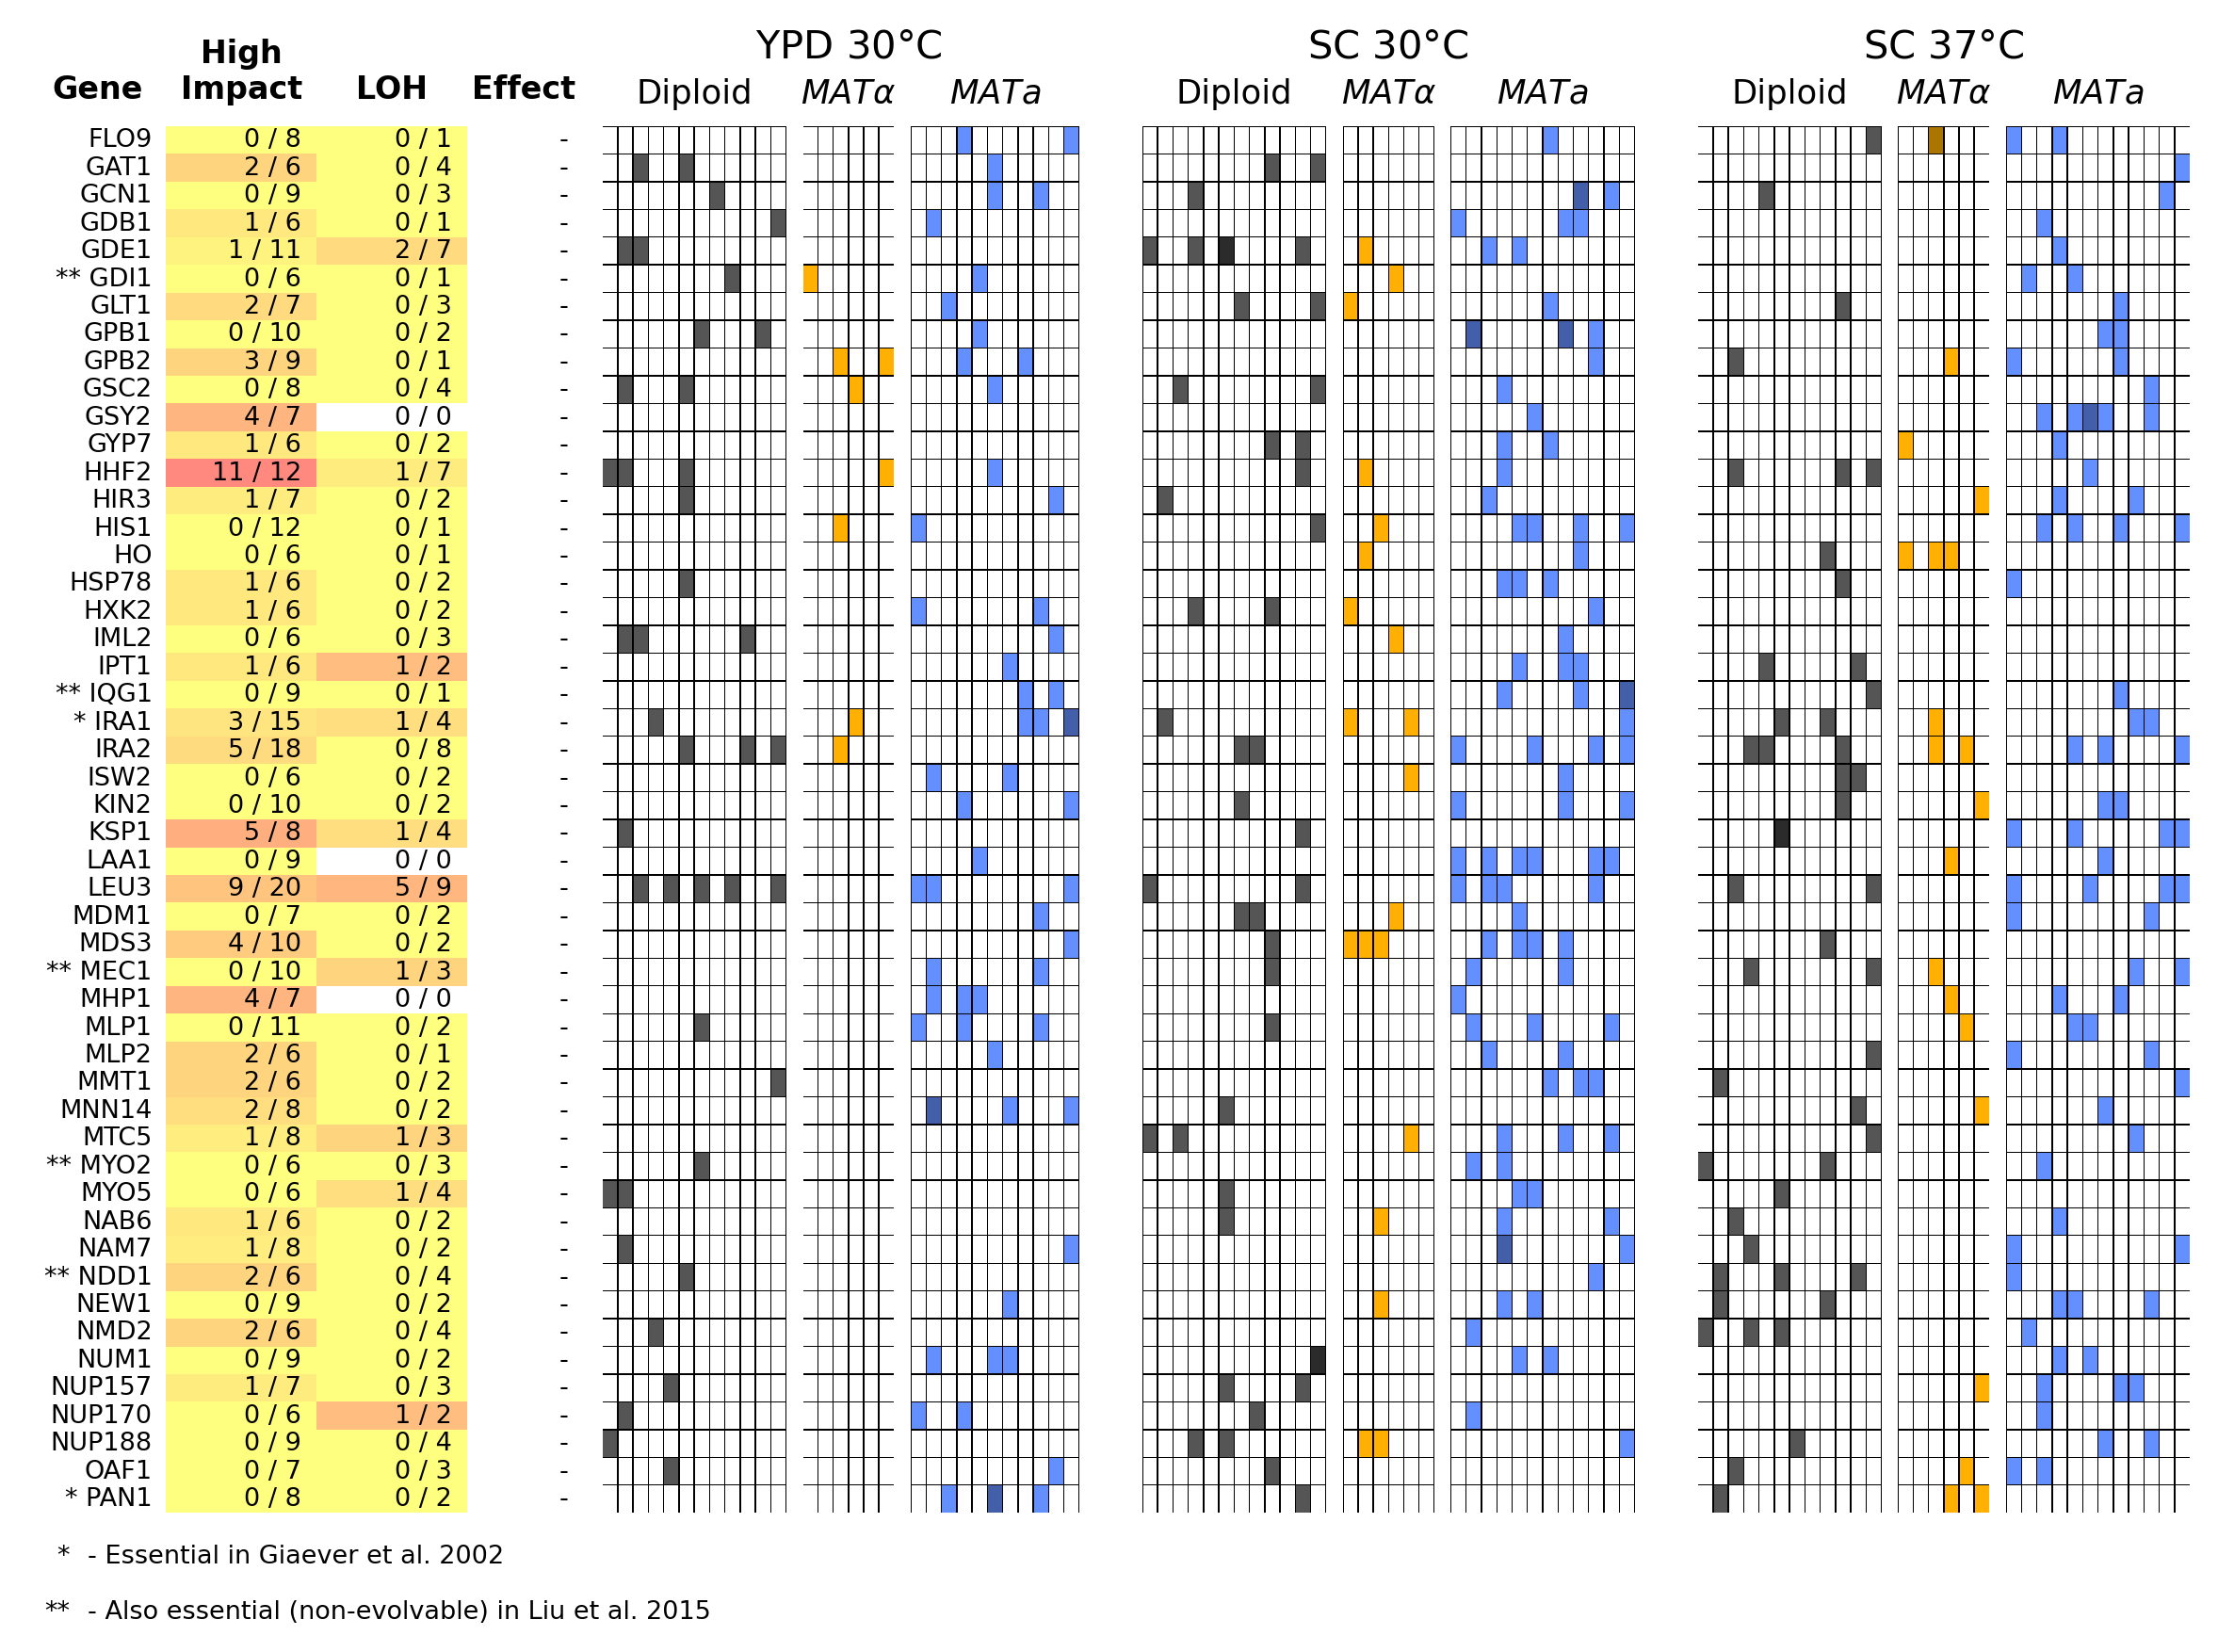

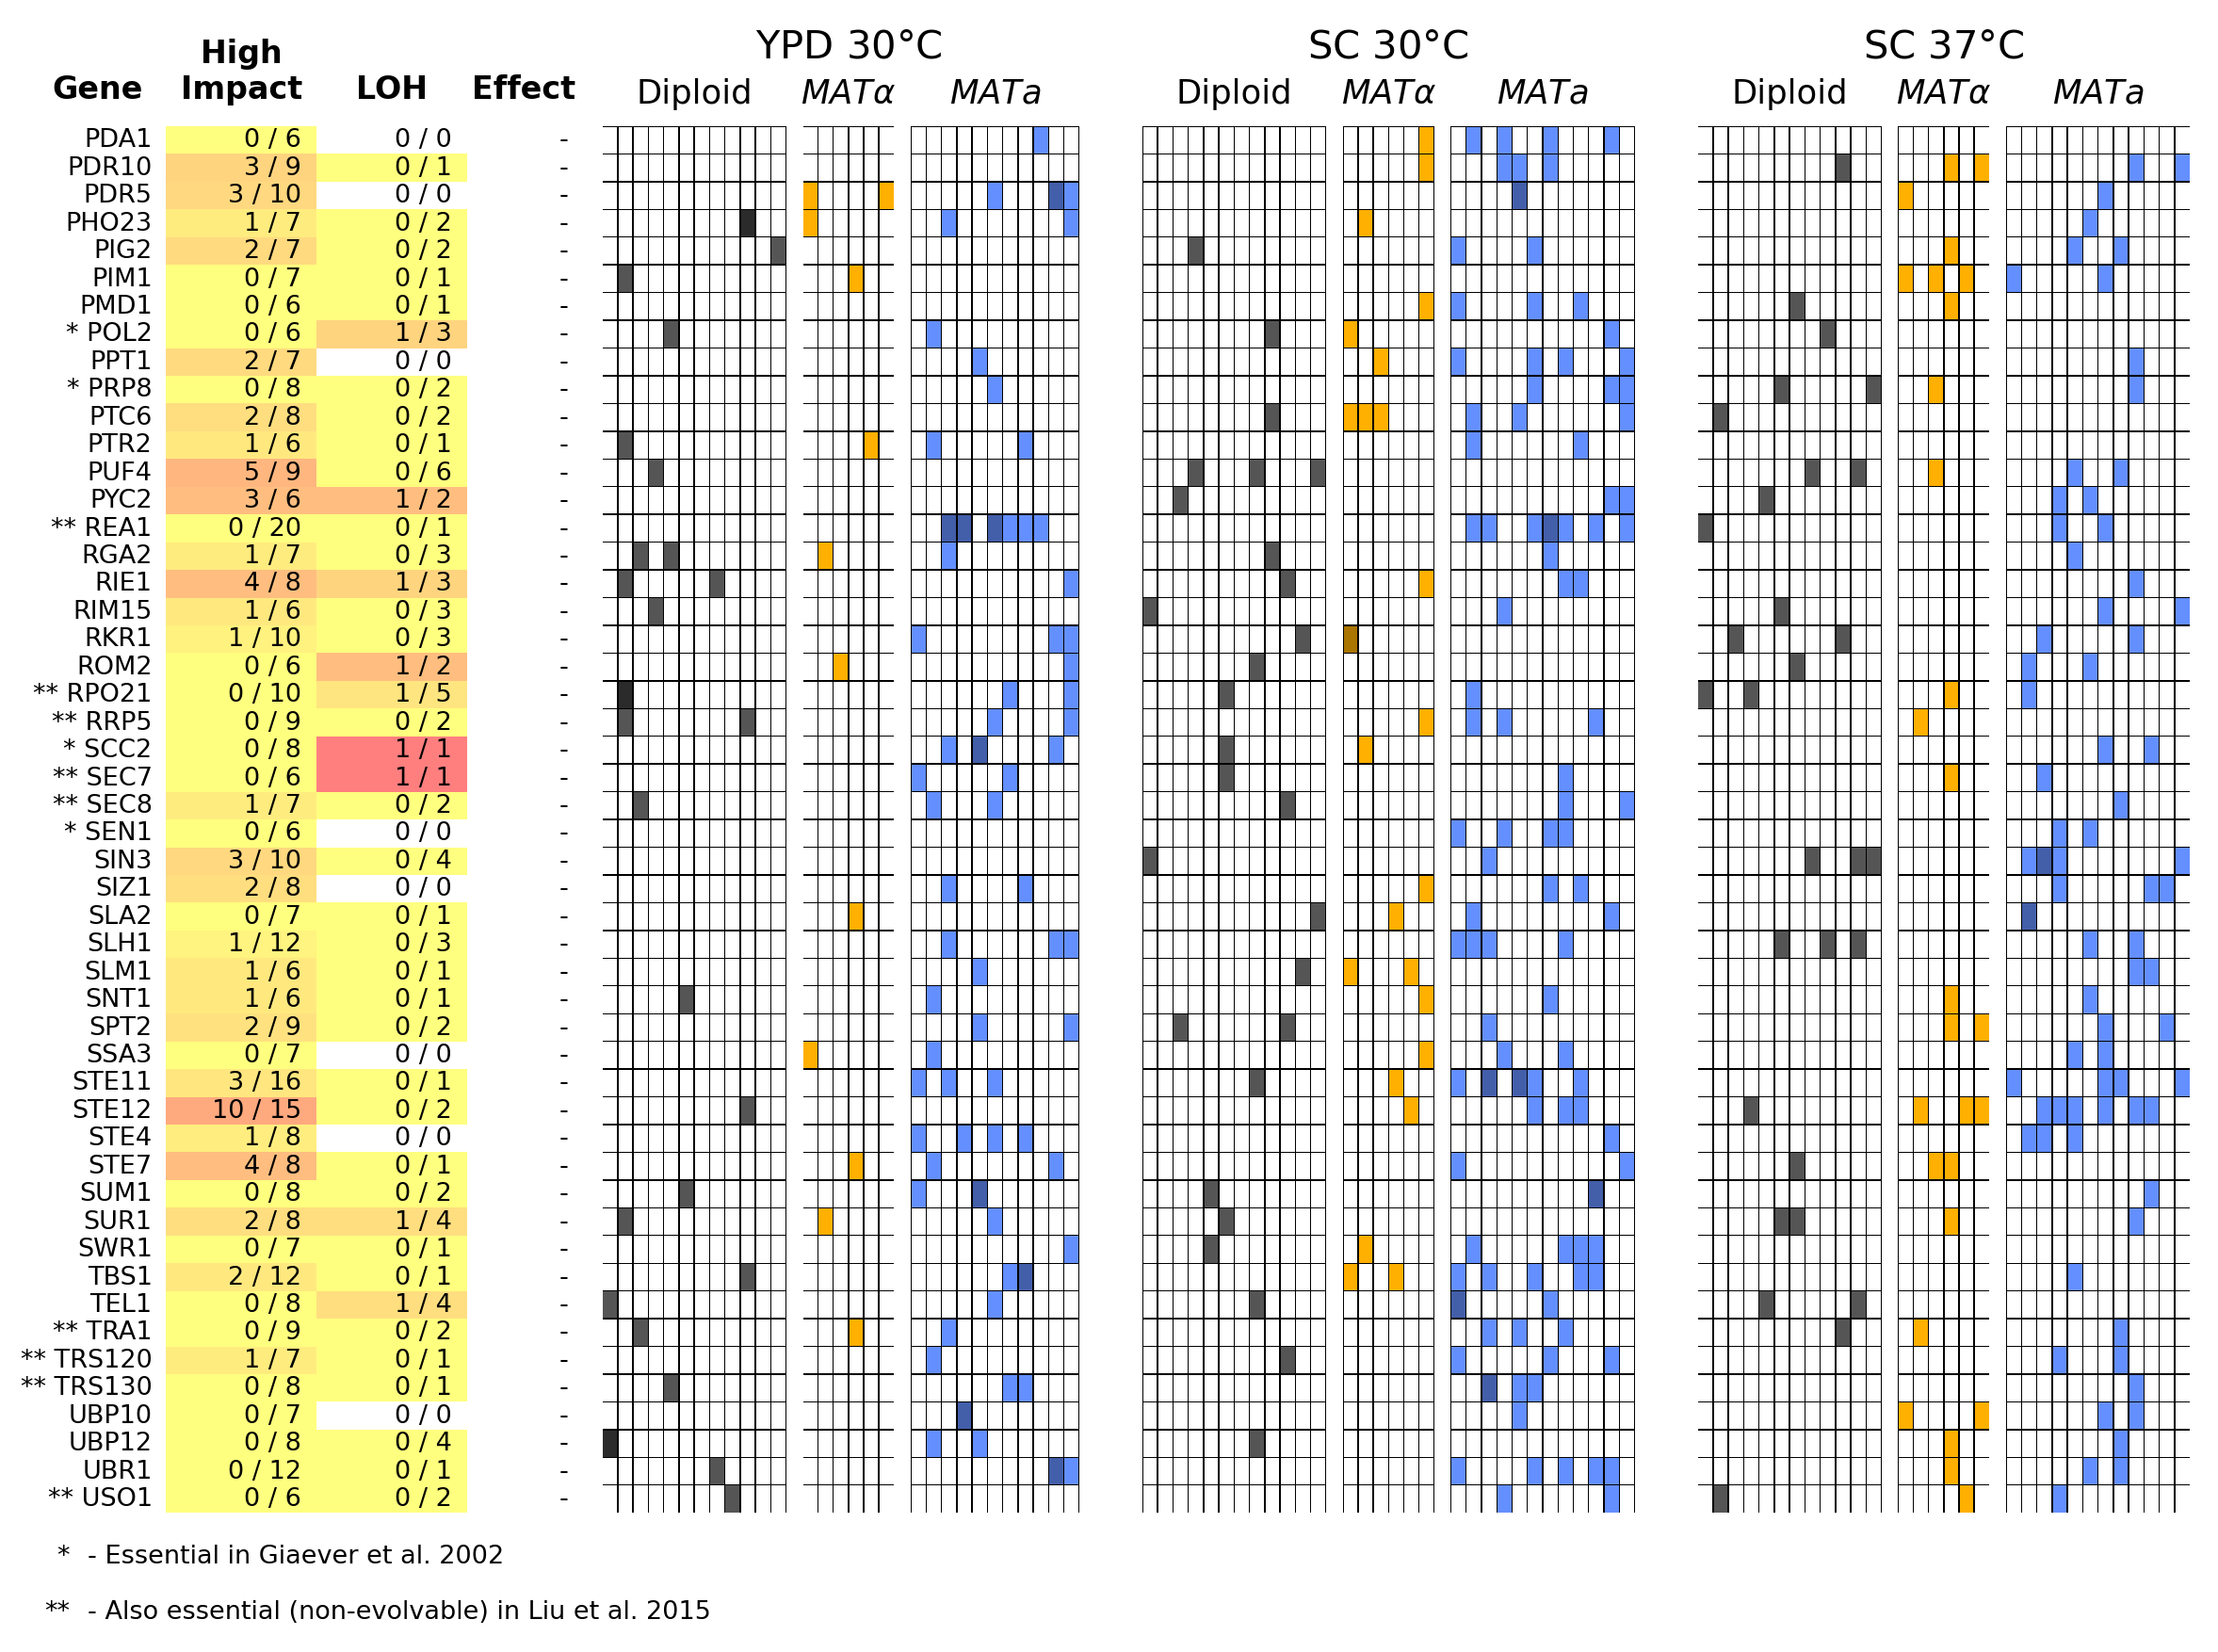

In [32]:
already_plotted = []
for g in gene_lists:
    already_plotted += g
other_genes_list = list(multi_hit_df[~multi_hit_df['Gene_ORF'].isin(already_plotted)].sort_values(by='Gene_ORF')['Gene_ORF'])

for g in range(3):
    f = pl.figure(figsize=(7.25,6.5), dpi=300)
    pl.subplots_adjust(wspace=0.1)
    gap = 1
    wgaps = {'a': 4, 'alpha': 1, 'diploid': 1}
    gs0 = gridspec.GridSpec(len(all_of_em)+(len(groups_list)-1)*gap, len(wells)+wgaps['diploid']*6+wgaps['a']*2)
    gs = []
    running_num = 0

    info_columns = [('Gene', 'gene_ess', False), ('Fraction\nLikely LOF', 'frac_high', 'frac_high_num'), ('Fraction LOH\n(diploid)', 'frac_LOH', 'frac_LOH_num'), ('dep', 'dep', False)]
    gl_c = 0
    genes = other_genes_list[g*50:(g+1)*50]
    # Making graph
    running_w = 0
    gl_c += 1
    for p in range(3):
        for strain in strains:
            strain_col = to_rgba(color_by_strain[strain])
            if strain == 'diploid':
                strain_col_darker = (strain_col[0]-strain_col[0]/2, strain_col[1]-strain_col[1]/2, strain_col[2]-strain_col[2]/2, 1)
            else:
                strain_col_darker = (strain_col[0]-strain_col[0]/3, strain_col[1]-strain_col[1]/3, strain_col[2]-strain_col[2]/3, 1)
            custom_cmap = ListedColormap(['#BA324F', 'w', strain_col, strain_col_darker])
            wells_use = [w for w in ws if w[:2]==plates[p] and well_to_strain[w]==strain]
            tmp_gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[running_num:running_num+len(genes),running_w:running_w+len(wells_use)])
            sub = pl.Subplot(f, tmp_gs[0])
            f.add_subplot(sub)
            if running_w == 0:
                # Making table
                if running_num == 0:
                    top = 1.02
                    sub.annotate('Gene', xy=(-3.125+0.75/2, top), fontsize=8, xycoords='axes fraction', horizontalalignment='center', weight='bold')
                    sub.annotate('High\nImpact', xy=(-3.125+0.75+0.82/2, top), fontsize=8, xycoords='axes fraction', horizontalalignment='center', weight='bold')
                    sub.annotate('LOH', xy=(-3.125+0.75+0.82+0.82/2, top), fontsize=8, xycoords='axes fraction', horizontalalignment='center', weight='bold')
                    sub.annotate('Effect', xy=(-3.125+0.75+0.82+0.82+0.61/2, top), fontsize=8, xycoords='axes fraction', horizontalalignment='center', weight='bold')
                    sub.annotate('*', xy=(-2.9, -0.04), ha='right', va='bottom', xycoords="axes fraction", clip_on=False, fontsize=6.5)
                    sub.annotate('**', xy=(-2.9, -0.08), ha='right', va='bottom', xycoords="axes fraction", clip_on=False, fontsize=6.5)
                    sub.annotate('- Essential in Giaever et al. 2002', xy=(-2.8, -0.04), va='bottom', 
                                 xycoords="axes fraction", clip_on=False, fontsize=6.5)
                    sub.annotate('- Also essential (non-evolvable) in Liu et al. 2015', xy=(-2.8, -0.08), va='bottom', 
                                 xycoords="axes fraction", clip_on=False, fontsize=6.5)
                tmp_df = orf_hit_df[orf_hit_df['Gene_ORF'].isin(genes)]
                tmp_df['sorter'] = tmp_df['Gene_ORF'].apply(lambda g: genes.index(g))
                tmp_df = tmp_df.sort_values(by='sorter')
                cell_colors = []
                for jnk, entry in tmp_df.iterrows():
                    tmprow = []
                    for i in info_columns:
                        if i[2] in entry:
                            if entry[i[2]] == -1:
                                tmprow.append('w')
                            else:
                                tmpcolor = colorscale(entry[i[2]])
                                tmprow.append((tmpcolor[0], tmpcolor[1], tmpcolor[2], 0.5))
                        else:
                            tmprow.append('w')
                    cell_colors.append(tmprow)
                tmp_table = sub.table(cellText=tmp_df.as_matrix([i[1] for i in info_columns]), bbox=[-3.125, 0, 3, 1], colWidths=[0.75, 0.82, 0.82, 0.61], cellColours=cell_colors)
                tmp_table.auto_set_font_size(False)
                tmp_table.set_fontsize(6.5)
                for key, cell in tmp_table.get_celld().items():
                    cell.set_linewidth(0)
                
                    
            ghmap = np.array(get_genehit_map(genes, wells_use))
            sns.heatmap(np.clip(ghmap, -1, 2), ax=sub, cmap=custom_cmap, cbar=False, linewidths=0.1, linecolor='k', vmin=-1, vmax=2)
            if running_num == 0: # top of graph
                sub.set_title(strains_for_print[strain], fontsize=8.5)
                if strain == 'alpha':
                    sub.annotate(plate2env[plates[p]], xy=(0.5, 1.05), fontsize=10, xycoords='axes fraction', horizontalalignment='center')
            sub.set_xticks([])
            sub.set_yticks([])
            sub.tick_params(which='both', axis='both', length=0, labelbottom=False, labeltop=False)
            running_w += len(wells_use) + wgaps[strain]
    running_num += len(genes)+gap
    
    f.savefig('../../FINAL_FIGURES/supp/Fig6Supp' + str(g+1) + '.pdf', background='transparent', bbox_inches='tight', pad_inches=0.1)

## Supplement fig: all that depend on strain / env

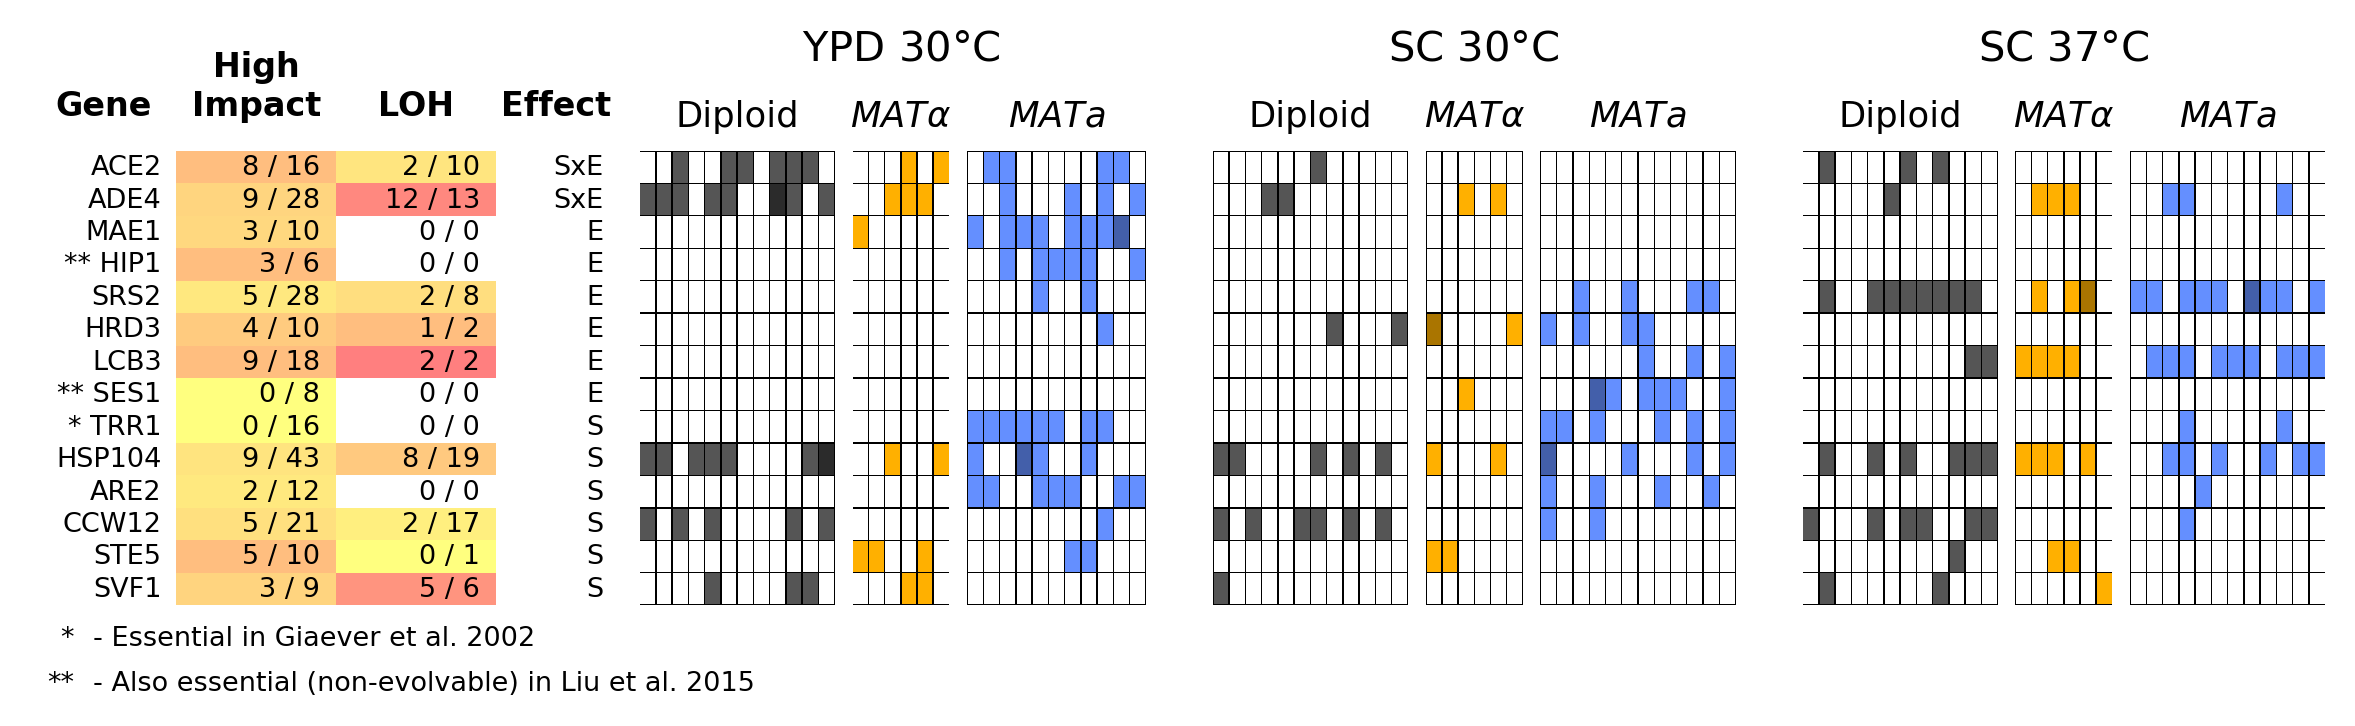

In [31]:
gene_lists = [list(multi_hit_df[pd.notnull(multi_hit_df['dependent_on'])].sort_values(by='dependent_on')['Gene_ORF'])]
f = pl.figure(figsize=(7.25,6.5), dpi=300)
pl.subplots_adjust(wspace=0.1)
gap = 1
wgaps = {'a': 4, 'alpha': 1, 'diploid': 1}
gs0 = gridspec.GridSpec(len(all_of_em)+(len(groups_list)-1)*gap, len(wells)+wgaps['diploid']*6+wgaps['a']*2)
gs = []
running_num = 0

info_columns = [('Gene', 'gene_ess', False), ('Fraction\nLikely LOF', 'frac_high', 'frac_high_num'), ('Fraction LOH\n(diploid)', 'frac_LOH', 'frac_LOH_num'), ('dep', 'dep', False)]
gl_c = 0
for genes in gene_lists:
    # Making graph
    running_w = 0
    gl_c += 1
    for p in range(3):
        for strain in strains:
            strain_col = to_rgba(color_by_strain[strain])
            if strain == 'diploid':
                strain_col_darker = (strain_col[0]-strain_col[0]/2, strain_col[1]-strain_col[1]/2, strain_col[2]-strain_col[2]/2, 1)
            else:
                strain_col_darker = (strain_col[0]-strain_col[0]/3, strain_col[1]-strain_col[1]/3, strain_col[2]-strain_col[2]/3, 1)
            custom_cmap = ListedColormap(['#BA324F', 'w', strain_col, strain_col_darker])
            wells_use = [w for w in ws if w[:2]==plates[p] and well_to_strain[w]==strain]
            tmp_gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[running_num:running_num+len(genes),running_w:running_w+len(wells_use)])
            sub = pl.Subplot(f, tmp_gs[0])
            f.add_subplot(sub)
            if running_w == 0:
                # Making table
                if running_num == 0:
                    top = 1.08
                    sub.annotate('Gene', xy=(-3.125+0.75/2, top), fontsize=8, xycoords='axes fraction', horizontalalignment='center', weight='bold')
                    sub.annotate('High\nImpact', xy=(-3.125+0.75+0.82/2, top), fontsize=8, xycoords='axes fraction', horizontalalignment='center', weight='bold')
                    sub.annotate('LOH', xy=(-3.125+0.75+0.82+0.82/2, top), fontsize=8, xycoords='axes fraction', horizontalalignment='center', weight='bold')
                    sub.annotate('Effect', xy=(-3.125+0.75+0.82+0.82+0.61/2, top), fontsize=8, xycoords='axes fraction', horizontalalignment='center', weight='bold')
                if gl_c == len(gene_lists):
                    sub.annotate('*', xy=(-2.9, -0.1), ha='right', va='bottom', xycoords="axes fraction", clip_on=False, fontsize=6.5)
                    sub.annotate('**', xy=(-2.9, -0.2), ha='right', va='bottom', xycoords="axes fraction", clip_on=False, fontsize=6.5)
                    sub.annotate('- Essential in Giaever et al. 2002', xy=(-2.8, -0.1), va='bottom', 
                                 xycoords="axes fraction", clip_on=False, fontsize=6.5)
                    sub.annotate('- Also essential (non-evolvable) in Liu et al. 2015', xy=(-2.8, -0.2), va='bottom', 
                                 xycoords="axes fraction", clip_on=False, fontsize=6.5)
                tmp_df = orf_hit_df[orf_hit_df['Gene_ORF'].isin(genes)]
                tmp_df['sorter'] = tmp_df['Gene_ORF'].apply(lambda g: genes.index(g))
                tmp_df = tmp_df.sort_values(by='sorter')
                cell_colors = []
                for jnk, entry in tmp_df.iterrows():
                    tmprow = []
                    for i in info_columns:
                        if i[2] in entry:
                            if entry[i[2]] == -1:
                                tmprow.append('w')
                            else:
                                tmpcolor = colorscale(entry[i[2]])
                                tmprow.append((tmpcolor[0], tmpcolor[1], tmpcolor[2], 0.5))
                        else:
                            tmprow.append('w')
                    cell_colors.append(tmprow)
                tmp_table = sub.table(cellText=tmp_df.as_matrix([i[1] for i in info_columns]), bbox=[-3.125, 0, 3, 1], colWidths=[0.75, 0.82, 0.82, 0.61], cellColours=cell_colors)
                tmp_table.auto_set_font_size(False)
                tmp_table.set_fontsize(6.5)
                for key, cell in tmp_table.get_celld().items():
                    cell.set_linewidth(0)
                
                    
            ghmap = np.array(get_genehit_map(genes, wells_use))
            sns.heatmap(np.clip(ghmap, -1, 2), ax=sub, cmap=custom_cmap, cbar=False, linewidths=0.1, linecolor='k', vmin=-1, vmax=2)
            if running_num == 0: # top of graph
                sub.set_title(strains_for_print[strain], fontsize=8.5)
                if strain == 'alpha':
                    sub.annotate(plate2env[plates[p]], xy=(0.5, 1.2), fontsize=10, xycoords='axes fraction', horizontalalignment='center')
            sub.set_xticks([])
            sub.set_yticks([])
            sub.tick_params(which='both', axis='both', length=0, labelbottom=False, labeltop=False)
            running_w += len(wells_use) + wgaps[strain]
    running_num += len(genes)+gap
    
f.savefig('../../FINAL_FIGURES/supp/Fig6Supp4.pdf', background='transparent', bbox_inches='tight', pad_inches=0.1)

## Let's look at the position of mutations in all genes with no high impact hits in case there is a signature of specific gain of function:

In [32]:
def protein_fraction(aa_pos):
    pos, length = aa_pos.split('/')
    return int(pos)/int(length)

mat = []
for well in wells:
    plate = well[:2]
    strain = well_to_strain[well]
    td = well_dats[well][(well_dats[well]['fixed_by_10150']) & pd.notnull(well_dats[well]['ORF_hit'])]
    mgs_seen = set()
    for entry in np.array(td[['ORF_hit', 'ANN', 'mutation_group', 'mutation_type', 'mutation_impact', ]]):
        if entry[2] not in mgs_seen:
            mgs_seen.add(entry[2])
            mat.append([well, plate, strain, entry[0], entry[3], entry[4], entry[1].split('|')[13]])

all_mutation_locations = pd.DataFrame(mat, columns=['Well', 'Plate', 'Strain', 'ORF_hit', 'mutation_type', 'mutation_impact', 'AA_pos'])
all_mutation_locations['Position In Gene'] = np.clip(all_mutation_locations['AA_pos'].apply(lambda a: protein_fraction(a)), 0, 1)
all_mutation_locations['Gene'] = all_mutation_locations['ORF_hit'].apply(lambda o: o2g.get(o, o))
all_mutation_locations['Essential'] = all_mutation_locations['ORF_hit'].isin(essential_orfs_by_Liu)

In [33]:
not_high_impact = orf_hit_df[(orf_hit_df['num_hits']>=10) & (orf_hit_df['frac_high'].apply(lambda s: s[0]=='0'))].sort_values(by='num_hits')
len(not_high_impact)

14

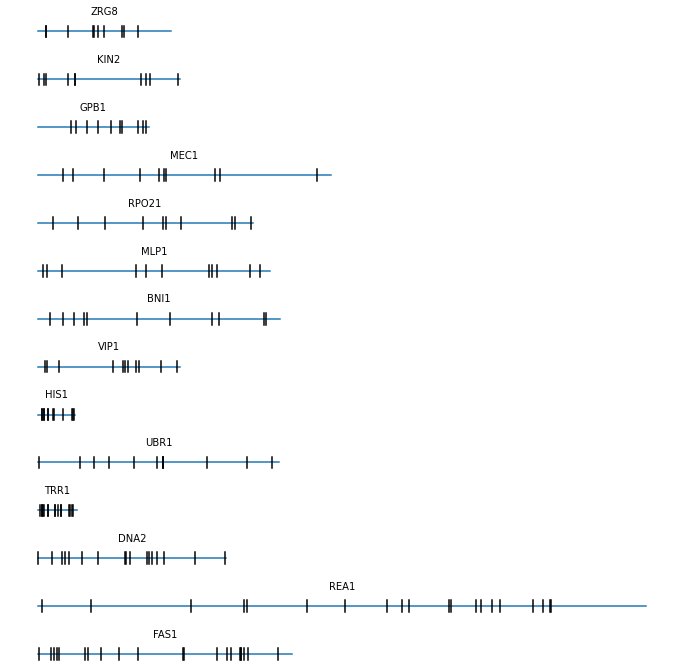

In [34]:
f, subs = pl.subplots(14, 1, figsize=(12,12), sharex=True, sharey=True)
pl.subplots_adjust(hspace=0.6)
c = 0
for jnk, row in not_high_impact.iterrows():
    sub = subs[c]
    c += 1
    sub.plot([0, row['size']], [0, 0])
    sub.annotate(row['Gene_ORF'], xy=(row['size']/2, 3), xycoords='data', ha='center')
    sub.set_yticks([])
    if c < 14:
        sub.set_xticks([])
    td = all_mutation_locations[all_mutation_locations['ORF_hit']==row['ORF']]
    for jnk2, row2 in td.iterrows():
        sub.plot([row2['Position In Gene']*row['size'], row2['Position In Gene']*row['size']], [-1, 1], c='k')
    sub.set_ylim([-1.2, 4])
sns.despine(bottom=True, left=True)

## nothing convincing...

### Getting a couple simple stats:

In [35]:
coverages = {'diploid': [], 'haploid': []}
for well in wells:
    if well_to_strain[well] == 'diploid':
        strain_use = 'diploid'
    else:
        strain_use = 'haploid'
    td = well_dats[well]
    use_gens = [g for g in seq_gens if 'G'+str(g)+'_ref_counts' in td]
    tmp = np.sum(td[['G'+str(g)+'_ref_counts' for g in use_gens] + ['G'+str(g)+'_alt_counts' for g in use_gens]], axis=0)
    for gen in use_gens:
        coverages[strain_use].append((tmp['G' + str(gen) + '_ref_counts'] + tmp['G' + str(gen) + '_alt_counts'])/len(td))

In [36]:
for s in coverages:
    print(s, np.mean(coverages[s]))

diploid 40.43054559546919
haploid 19.7774860133638


In [37]:
gene_info2 = pd.read_csv('../accessory_files/yeast_gene_annotations.tsv', delimiter='\t')
len(gene_info2[gene_info2['featureType']=='ORF'])

6601